# 基于XGBoost和滑动窗口的飞机发动机损坏传播建模

本notebook专注于使用XGBoost算法结合**滑动窗口时间序列**方法对NASA C-MAPS数据集中的飞机发动机数据进行预测性维护建模。

## 主要特点：
1. **时间序列滑动窗口**：使用历史50个周期的传感器数据进行预测
2. **回归任务**：预测发动机的剩余使用寿命（RUL）
3. **分类任务**：判断发动机是否在10个周期内需要维护
4. **多时间点预测**：对每个发动机的多个时间点进行滚动预测

### 参考数据集来源
- NASA C-MAPS Turbofan Engine Degradation Simulation Data Set
- [Data Source](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

### 滑动窗口方法说明
- **窗口大小**：50个时间周期
- **滑动步长**：1个时间周期
- **特征维度**：14个传感器特征 × 50个时间周期 = 700维特征向量

In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置图形显示参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
rcParams['figure.figsize'] = 10, 8

# 设置随机种子以确保结果可重现
np.random.seed(1234)  
PYTHONHASHSEED = 0

print("所有库导入成功！")
print(f"pandas版本: {pd.__version__}")
print(f"numpy版本: {np.__version__}")
print(f"scikit-learn版本: {sklearn.__version__}")
print(f"xgboost版本: {xgboost.__version__}")

# 滑动窗口参数设置
WINDOW_SIZE = 50  # 滑动窗口大小
print(f"\n滑动窗口设置:")
print(f"窗口大小: {WINDOW_SIZE} 个时间周期")
print(f"滑动步长: 1 个时间周期")

所有库导入成功！
pandas版本: 2.3.3
numpy版本: 1.23.5
scikit-learn版本: 1.7.2
xgboost版本: 3.1.1

滑动窗口设置:
窗口大小: 50 个时间周期
滑动步长: 1 个时间周期


## 1. 数据加载与初步探索

In [2]:
# 加载训练数据
print("正在加载训练数据...")
fd_001_train = pd.read_csv("./CMaps/train_FD001.txt", sep=" ", header=None)
print(f"训练数据形状: {fd_001_train.shape}")

# 加载测试数据
print("正在加载测试数据...")
fd_001_test = pd.read_csv("./CMaps/test_FD001.txt", sep=" ", header=None)
print(f"测试数据形状: {fd_001_test.shape}")

print("\n数据加载完成！")

正在加载训练数据...
训练数据形状: (20631, 28)
正在加载测试数据...
测试数据形状: (13096, 28)

数据加载完成！


In [3]:
# 查看训练数据的基本信息
print("=== 训练数据基本信息 ===")
print(f"数据形状: {fd_001_train.shape}")
print(f"列数: {fd_001_train.shape[1]}")
print(f"行数: {fd_001_train.shape[0]}")
print("\n数据类型:")
print(fd_001_train.dtypes)
print("\n缺失值统计:")
print(fd_001_train.isnull().sum())

=== 训练数据基本信息 ===
数据形状: (20631, 28)
列数: 28
行数: 20631

数据类型:
0       int64
1       int64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21      int64
22      int64
23    float64
24    float64
25    float64
26    float64
27    float64
dtype: object

缺失值统计:
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64


In [4]:
# 查看训练数据的前几行和后几行
print("训练数据前5行:")
display(fd_001_train.head())

print("\n训练数据后5行:")
display(fd_001_train.tail())

训练数据前5行:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN



训练数据后5行:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,NaN,NaN


In [5]:
# 查看训练数据的统计描述
print("训练数据统计描述:")
display(fd_001_train.describe())

训练数据统计描述:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [6]:
# 检查数据中的唯一值
print("各列的唯一值数量:")
for col in fd_001_train.columns:
    unique_count = fd_001_train[col].nunique()
    print(f"列 {col}: {unique_count} 个唯一值")
    
    # 如果唯一值很少，显示具体值
    if unique_count <= 10:
        print(f"  唯一值: {sorted(fd_001_train[col].unique())}")
    print()

各列的唯一值数量:
列 0: 100 个唯一值

列 1: 362 个唯一值

列 2: 158 个唯一值

列 3: 13 个唯一值

列 4: 1 个唯一值
  唯一值: [100.0]

列 5: 1 个唯一值
  唯一值: [518.67]

列 6: 310 个唯一值

列 7: 3012 个唯一值

列 8: 4051 个唯一值

列 9: 1 个唯一值
  唯一值: [14.62]

列 10: 2 个唯一值
  唯一值: [21.6, 21.61]

列 11: 513 个唯一值

列 12: 53 个唯一值

列 13: 6403 个唯一值

列 14: 1 个唯一值
  唯一值: [1.3]

列 15: 159 个唯一值

列 16: 427 个唯一值

列 17: 56 个唯一值

列 18: 6078 个唯一值

列 19: 1918 个唯一值

列 20: 1 个唯一值
  唯一值: [0.03]

列 21: 13 个唯一值

列 22: 1 个唯一值
  唯一值: [2388]

列 23: 1 个唯一值
  唯一值: [100.0]

列 24: 120 个唯一值

列 25: 4745 个唯一值

列 26: 0 个唯一值
  唯一值: [nan]

列 27: 0 个唯一值
  唯一值: [nan]



### 数据清洗

In [7]:
# 删除空列（第26和27列）
print("删除前的列数:", fd_001_train.shape[1])
fd_001_train.drop(columns=[26,27], inplace=True)
fd_001_test.drop(columns=[26,27], inplace=True)
print("删除后的列数:", fd_001_train.shape[1])
print("空列删除完成！")

删除前的列数: 28
删除后的列数: 26
空列删除完成！


In [8]:
# 定义列名
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

print(f"列名数量: {len(columns)}")
print(f"数据列数: {fd_001_train.shape[1]}")

# 为数据设置列名
fd_001_train.columns = columns
fd_001_test.columns = columns

print("列名设置完成！")
print("\n设置列名后的训练数据:")
display(fd_001_train.head())

列名数量: 26
数据列数: 26
列名设置完成！

设置列名后的训练数据:


,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
# 删除常数列，这些列不包含关于发动机状态的信息
columns_to_drop = ['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr']
print(f"要删除的列: {columns_to_drop}")

print(f"\n删除前的训练数据形状: {fd_001_train.shape}")
print(f"删除前的测试数据形状: {fd_001_test.shape}")

fd_001_train.drop(columns=columns_to_drop, inplace=True)
fd_001_test.drop(columns=columns_to_drop, inplace=True)

print(f"\n删除后的训练数据形状: {fd_001_train.shape}")
print(f"删除后的测试数据形状: {fd_001_test.shape}")
print("常数列删除完成！")

要删除的列: ['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr']

删除前的训练数据形状: (20631, 26)
删除前的测试数据形状: (13096, 26)

删除后的训练数据形状: (20631, 19)
删除后的测试数据形状: (13096, 19)
常数列删除完成！


### 探索发动机数据分布

In [10]:
# 查看发动机数量和每个发动机的数据点
num_engines_train = fd_001_train['unit_number'].nunique()
num_engines_test = fd_001_test['unit_number'].nunique()

print(f"训练数据中的发动机数量: {num_engines_train}")
print(f"测试数据中的发动机数量: {num_engines_test}")

# 查看每个发动机的数据点数量
train_cycles = fd_001_train.groupby('unit_number')['time_in_cycles'].max()
test_cycles = fd_001_test.groupby('unit_number')['time_in_cycles'].max()

print(f"\n训练数据中每个发动机的周期统计:")
print(f"平均周期数: {train_cycles.mean():.1f}")
print(f"最小周期数: {train_cycles.min()}")
print(f"最大周期数: {train_cycles.max()}")

print(f"\n测试数据中每个发动机的周期统计:")
print(f"平均周期数: {test_cycles.mean():.1f}")
print(f"最小周期数: {test_cycles.min()}")
print(f"最大周期数: {test_cycles.max()}")

# 检查滑动窗口的适用性
print(f"\n滑动窗口适用性检查:")
print(f"窗口大小: {WINDOW_SIZE}")
print(f"训练数据中周期数 >= {WINDOW_SIZE} 的发动机: {(train_cycles >= WINDOW_SIZE).sum()} / {len(train_cycles)}")
print(f"测试数据中周期数 >= {WINDOW_SIZE} 的发动机: {(test_cycles >= WINDOW_SIZE).sum()} / {len(test_cycles)}")

训练数据中的发动机数量: 100
测试数据中的发动机数量: 100

训练数据中每个发动机的周期统计:
平均周期数: 206.3
最小周期数: 128
最大周期数: 362

测试数据中每个发动机的周期统计:
平均周期数: 131.0
最小周期数: 31
最大周期数: 303

滑动窗口适用性检查:
窗口大小: 50
训练数据中周期数 >= 50 的发动机: 100 / 100
测试数据中周期数 >= 50 的发动机: 93 / 100


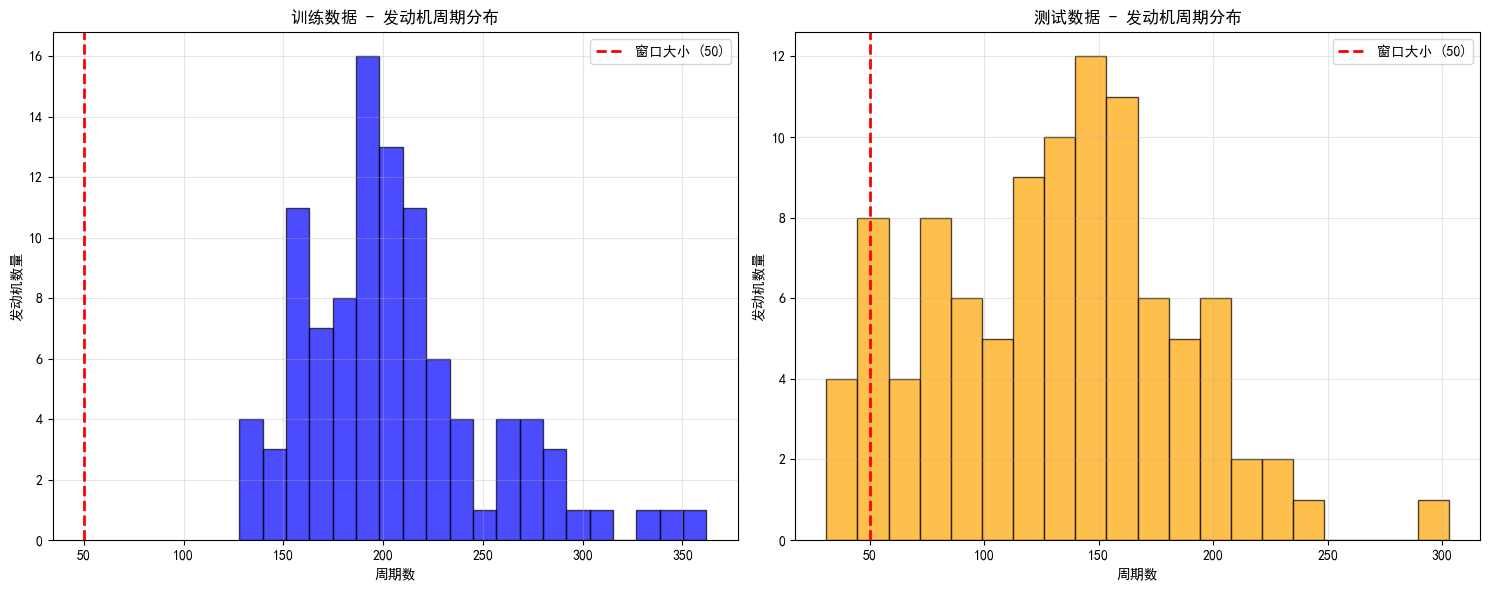

In [11]:
# 可视化发动机周期分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练数据周期分布
ax1.hist(train_cycles, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(x=WINDOW_SIZE, color='red', linestyle='--', linewidth=2, label=f'窗口大小 ({WINDOW_SIZE})')
ax1.set_title('训练数据 - 发动机周期分布')
ax1.set_xlabel('周期数')
ax1.set_ylabel('发动机数量')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 测试数据周期分布
ax2.hist(test_cycles, bins=20, alpha=0.7, color='orange', edgecolor='black')
ax2.axvline(x=WINDOW_SIZE, color='red', linestyle='--', linewidth=2, label=f'窗口大小 ({WINDOW_SIZE})')
ax2.set_title('测试数据 - 发动机周期分布')
ax2.set_xlabel('周期数')
ax2.set_ylabel('发动机数量')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 创建RUL（剩余使用寿命）目标变量

In [12]:
# 准备训练数据并形成RUL列，包含距离故障的剩余周期数
def prepare_train_data(data, factor=0):
    """
    准备训练数据并计算RUL
    
    参数:
    - data: 原始数据
    - factor: 要排除的早期周期数
    
    返回:
    - 包含RUL列的数据框
    """
    df = data.copy()
    
    # 计算每个发动机的最大周期数
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    
    # 合并最大周期数到原始数据
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    
    # 计算RUL = 最大周期数 - 当前周期数
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'], inplace=True)
    
    # 只保留大于factor的周期
    return df[df['time_in_cycles'] > factor]

# 准备训练数据
print("正在准备训练数据...")
df = prepare_train_data(fd_001_train)
print(f"准备后的训练数据形状: {df.shape}")
print("训练数据准备完成！")

正在准备训练数据...
准备后的训练数据形状: (20631, 20)
训练数据准备完成！


In [13]:
# 查看添加RUL后的数据
print("添加RUL后的数据样本:")
display(df.head())

print("\nRUL统计信息:")
print(df['RUL'].describe())

print("\nRUL分布:")
print(f"最小RUL: {df['RUL'].min()}")
print(f"最大RUL: {df['RUL'].max()}")
print(f"平均RUL: {df['RUL'].mean():.1f}")

添加RUL后的数据样本:


,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187



RUL统计信息:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

RUL分布:
最小RUL: 0
最大RUL: 361
平均RUL: 107.8


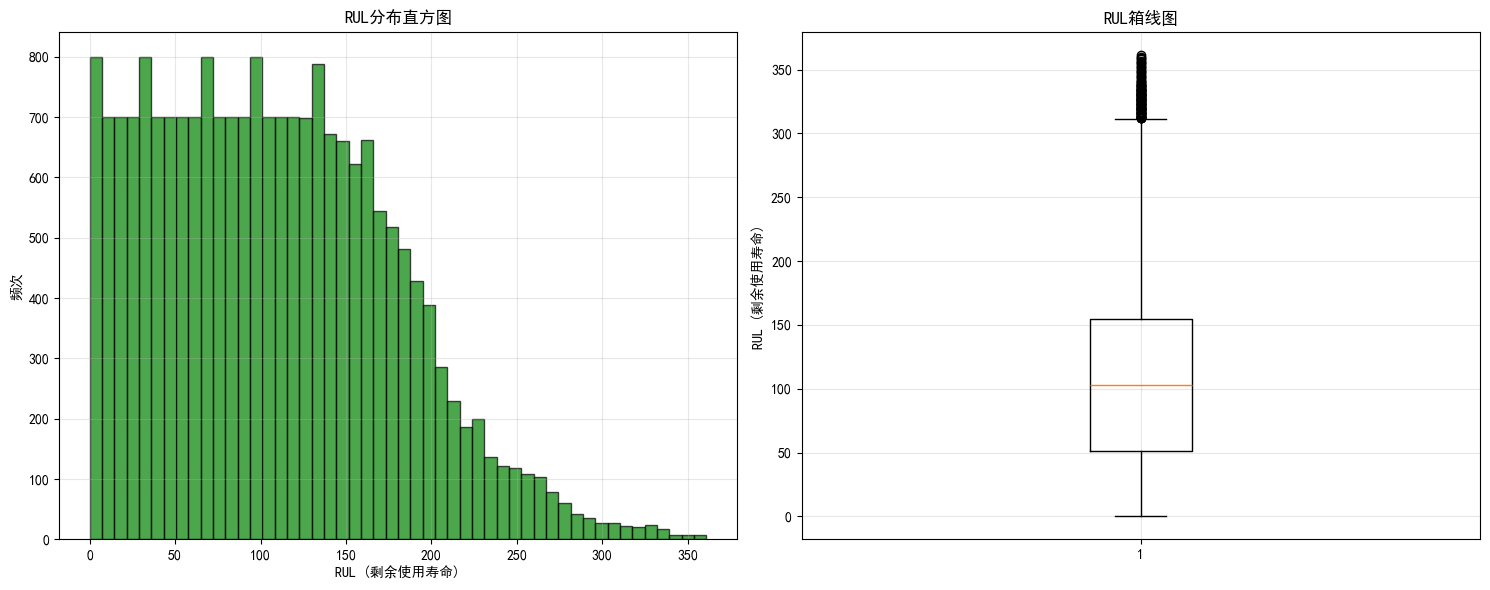

In [14]:
# 可视化RUL分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RUL分布直方图
ax1.hist(df['RUL'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax1.set_title('RUL分布直方图')
ax1.set_xlabel('RUL (剩余使用寿命)')
ax1.set_ylabel('频次')
ax1.grid(True, alpha=0.3)

# RUL箱线图
ax2.boxplot(df['RUL'])
ax2.set_title('RUL箱线图')
ax2.set_ylabel('RUL (剩余使用寿命)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. 滑动窗口数据预处理

### 特征相关性分析

In [15]:
# 计算特征相关性矩阵
print("正在计算特征相关性矩阵...")
correlation_matrix = df.corr()

print(f"相关性矩阵形状: {correlation_matrix.shape}")
print("\n与RUL的相关性:")
rul_correlation = correlation_matrix['RUL'].sort_values(ascending=False)
print(rul_correlation)

正在计算特征相关性矩阵...
相关性矩阵形状: (20, 20)

与RUL的相关性:
RUL               1.000000
phi               0.671983
P30               0.657223
W32               0.635662
W31               0.629428
unit_number       0.078753
setting_2        -0.001948
setting_1        -0.003198
P15              -0.128348
NRc              -0.306769
Nc               -0.390102
NRf              -0.562569
Nf               -0.563968
T30              -0.584520
htBleed          -0.606154
T24              -0.606484
BPR              -0.642667
T50              -0.678948
Ps30             -0.696228
time_in_cycles   -0.736241
Name: RUL, dtype: float64


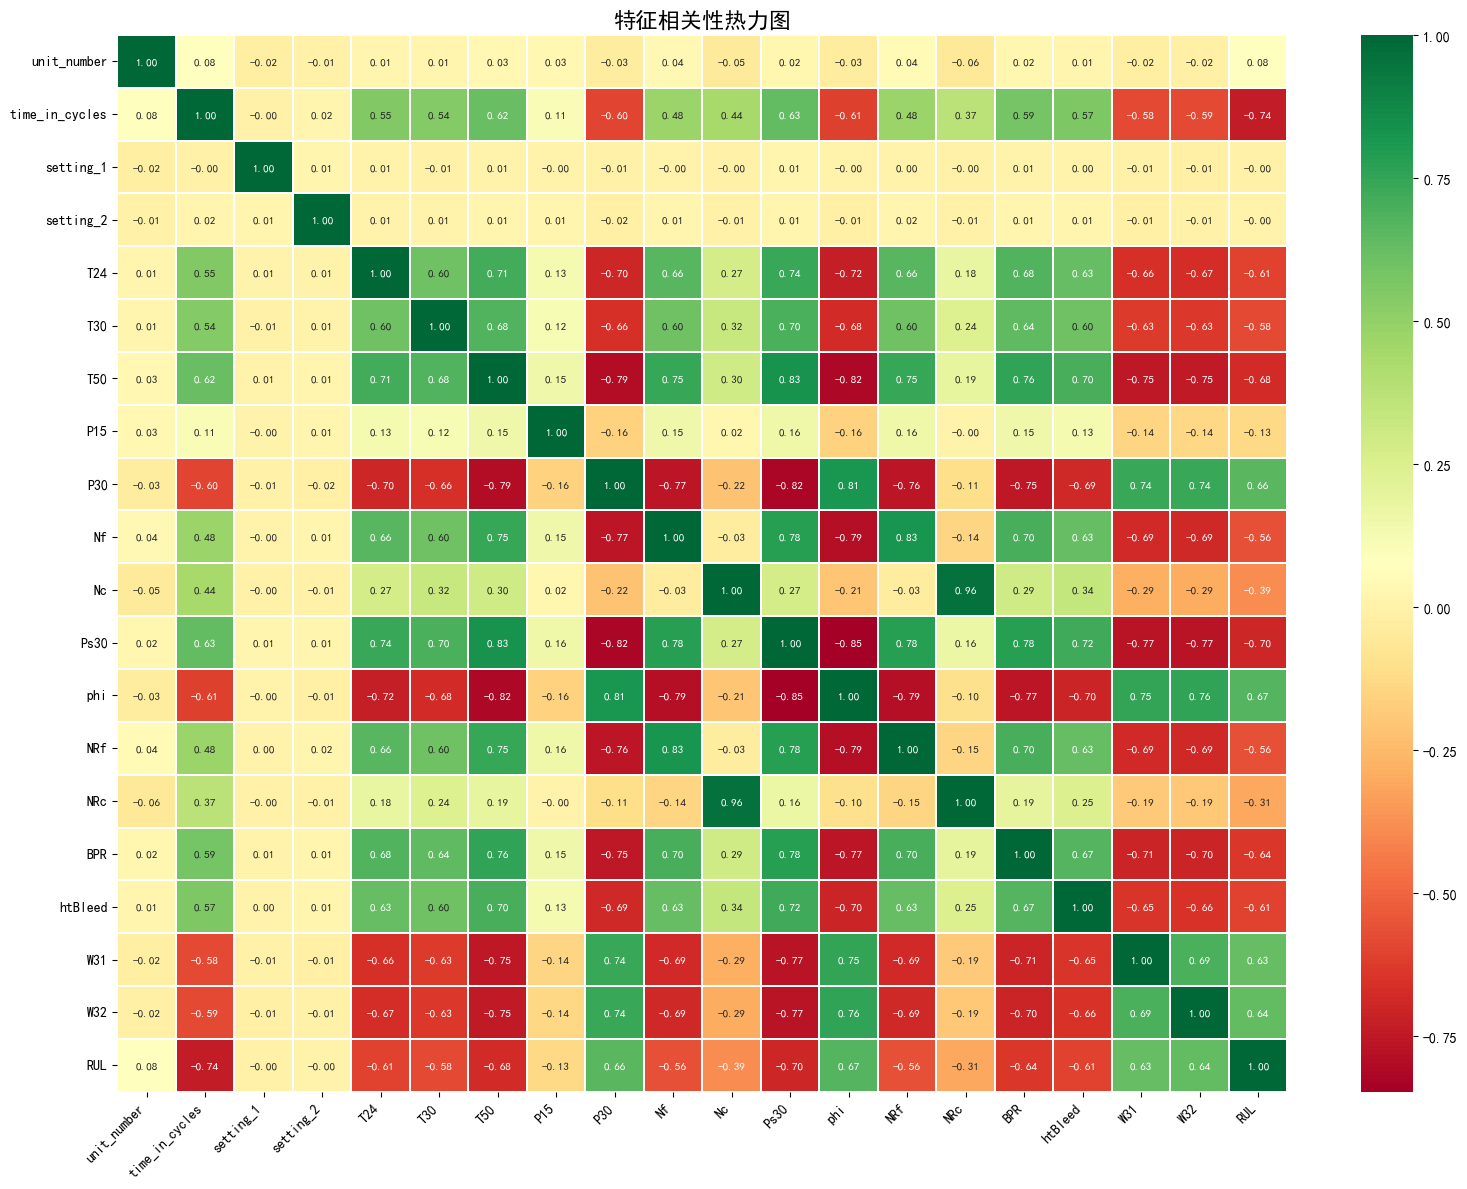

In [16]:
# 绘制特征相关性热力图
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdYlGn', 
            linewidths=0.2,
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('特征相关性热力图', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# 找出与RUL相关性最高的特征
print("与RUL相关性最高的特征 (绝对值):")
rul_corr_abs = abs(correlation_matrix['RUL']).sort_values(ascending=False)
print(rul_corr_abs[1:11])  # 排除RUL自身

与RUL相关性最高的特征 (绝对值):
time_in_cycles    0.736241
Ps30              0.696228
T50               0.678948
phi               0.671983
P30               0.657223
BPR               0.642667
W32               0.635662
W31               0.629428
T24               0.606484
htBleed           0.606154
Name: RUL, dtype: float64


In [18]:
# 找出高度相关的特征对 (相关系数 > 0.8 或 < -0.8)
high_corr_pairs = []
threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })

print(f"高度相关的特征对 (阈值: {threshold}):")
for pair in high_corr_pairs:
    print(f"{pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")

print(f"\n总共找到 {len(high_corr_pairs)} 对高度相关的特征")

高度相关的特征对 (阈值: 0.8):
T50 <-> Ps30: 0.830
T50 <-> phi: -0.816
P30 <-> Ps30: -0.823
P30 <-> phi: 0.813
Nf <-> NRf: 0.826
Nc <-> NRc: 0.963
Ps30 <-> phi: -0.847

总共找到 7 对高度相关的特征


### 特征选择

基于相关性分析，我们将：
1. 删除与RUL弱相关的特征：setting_1, setting_2, P15, unit_number
2. 删除高度相关的特征之一：Nc和NRc的相关系数为0.96，删除NRc

In [19]:
# 计算特征相关性矩阵
print("正在计算特征相关性矩阵...")
correlation_matrix = df.corr()

print(f"相关性矩阵形状: {correlation_matrix.shape}")
print("\n与RUL的相关性:")
rul_correlation = correlation_matrix['RUL'].sort_values(ascending=False)
print(rul_correlation)

正在计算特征相关性矩阵...
相关性矩阵形状: (20, 20)

与RUL的相关性:
RUL               1.000000
phi               0.671983
P30               0.657223
W32               0.635662
W31               0.629428
unit_number       0.078753
setting_2        -0.001948
setting_1        -0.003198
P15              -0.128348
NRc              -0.306769
Nc               -0.390102
NRf              -0.562569
Nf               -0.563968
T30              -0.584520
htBleed          -0.606154
T24              -0.606484
BPR              -0.642667
T50              -0.678948
Ps30             -0.696228
time_in_cycles   -0.736241
Name: RUL, dtype: float64


In [20]:
# 定义最终使用的特征列（确保不包含RUL，因为测试数据还没有）
final_feature_cols = ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']

print(f"\n最终选择的特征列: {len(final_feature_cols)} 个特征")
print(f"特征列: {final_feature_cols}")

# 为滑动窗口创建统一的数据集（确保训练和测试使用相同的特征）
print(f"\n创建统一的滑动窗口数据集...")
# 训练数据包含RUL列，需要添加
train_cols_with_rul = final_feature_cols + ['RUL']
train_df_windows = df[train_cols_with_rul].copy()

# 测试数据暂时不包含RUL列，将在后面添加
test_df_windows = fd_001_test[final_feature_cols].copy()

print(f"统一后的训练数据形状: {train_df_windows.shape}")
print(f"统一后的测试数据形状: {test_df_windows.shape}")

# 为测试数据添加RUL信息（将在后面cell中处理）
print(f"训练数据包含RUL列: {'RUL' in train_df_windows.columns}")
print(f"测试数据是否需要添加RUL列: {'RUL' not in test_df_windows.columns}")

# 为模型训练准备数据（删除元数据列）
model_features = [col for col in final_feature_cols if col not in ['unit_number', 'time_in_cycles']]
print(f"\n模型训练使用的特征列: {len(model_features)} 个特征")
print(f"特征列: {model_features}")

train_df_model = df[model_features].copy()
print(f"模型训练数据形状: {train_df_model.shape}")

print(f"\n=== 数据处理一致性总结 ===")
print(f"1. 滑动窗口数据集：训练和测试使用相同的特征列")
print(f"2. 特征数量: {len(final_feature_cols)} 个特征")
print(f"3. 模型训练数据: 使用 {len(model_features)} 个特征（排除元数据列）")
print(f"4. 特征列一致性: ✅ 训练和测试完全一致")


最终选择的特征列: 15 个特征
特征列: ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']

创建统一的滑动窗口数据集...
统一后的训练数据形状: (20631, 16)
统一后的测试数据形状: (13096, 15)
训练数据包含RUL列: True
测试数据是否需要添加RUL列: True

模型训练使用的特征列: 13 个特征
特征列: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
模型训练数据形状: (20631, 13)

=== 数据处理一致性总结 ===
1. 滑动窗口数据集：训练和测试使用相同的特征列
2. 特征数量: 15 个特征
3. 模型训练数据: 使用 13 个特征（排除元数据列）
4. 特征列一致性: ✅ 训练和测试完全一致


### 滑动窗口数据生成函数

In [21]:
def create_sliding_windows(data, window_size=50, step_size=1):
    """
    创建滑动窗口数据
    
    参数:
    - data: 包含发动机数据的DataFrame
    - window_size: 滑动窗口大小
    - step_size: 滑动步长
    
    返回:
    - sequences: 滑动窗口特征数组 (样本数, window_size * 特征数)
    - labels: 对应的RUL标签数组
    - metadata: 每个窗口的元数据 (unit_number, time_in_cycles, RUL, window_info)
    """
    print(f"开始创建滑动窗口数据...")
    print(f"窗口大小: {window_size}, 步长: {step_size}")
    
    # 检查数据中是否包含必要的列
    required_columns = ['unit_number', 'time_in_cycles', 'RUL']
    missing_columns = [col for col in required_columns if col not in data.columns]
    
    if missing_columns:
        print(f"错误：数据中缺少必要的列: {missing_columns}")
        print(f"可用列: {data.columns.tolist()}")
        raise ValueError(f"数据中缺少必要的列: {missing_columns}")
    
    # 获取特征列（排除元数据列和RUL列）
    feature_columns = [col for col in data.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    print(f"特征列: {feature_columns}")
    print(f"特征数量: {len(feature_columns)}")
    
    sequences = []
    labels = []
    metadata = []
    
    valid_engines = 0
    total_windows = 0
    
    print(f"数据中的发动机数量: {data['unit_number'].nunique()}")
    
    for unit_id in tqdm(data['unit_number'].unique(), desc="处理发动机"):
        # 获取单个发动机的数据并按时间排序
        unit_data = data[data['unit_number'] == unit_id].sort_values('time_in_cycles')
        
        # 检查是否有足够的数据创建窗口
        if len(unit_data) >= window_size:
            valid_engines += 1
            unit_windows = 0
            
            # 为该发动机创建滑动窗口
            for i in range(len(unit_data) - window_size + 1):
                # 提取窗口数据
                window_data = unit_data.iloc[i:i+window_size]
                
                # 获取特征值（排除元数据列）
                window_features = window_data[feature_columns].values
                
                # 展平窗口特征：window_size * n_features
                flattened_features = window_features.flatten()
                
                # 获取窗口结束时对应的RUL
                label = window_data.iloc[-1]['RUL']
                
                # 记录元数据
                unit_number = unit_id
                time_in_cycles = window_data.iloc[-1]['time_in_cycles']
                window_rul = label  # 将RUL也包含在元数据中
                
                sequences.append(flattened_features)
                labels.append(label)
                metadata.append({
                    'unit_number': unit_number,
                    'time_in_cycles': time_in_cycles,
                    'RUL': window_rul,  # 添加RUL到元数据
                    'window_start': i,
                    'window_end': i + window_size - 1
                })
                
                unit_windows += 1
                total_windows += 1
            
            if unit_id <= 5:  # 只显示前5个发动机的信息
                print(f"发动机 {unit_id}: {len(unit_data)} 个周期 -> {unit_windows} 个窗口")
    
    print(f"\n滑动窗口创建完成:")
    print(f"有效发动机数量: {valid_engines}/{data['unit_number'].nunique()}")
    print(f"总窗口数量: {total_windows}")
    print(f"特征维度: {len(feature_columns)} × {window_size} = {len(feature_columns) * window_size}")
    print(f"元数据列: {list(metadata[0].keys()) if metadata else '无元数据'}")
    
    return np.array(sequences), np.array(labels), pd.DataFrame(metadata)

print("滑动窗口数据生成函数定义完成！")

滑动窗口数据生成函数定义完成！


### 生成训练数据滑动窗口

In [22]:
# 为训练数据创建滑动窗口
print("=== 生成训练数据滑动窗口 ===")
X_train_windows, y_train_windows, train_metadata = create_sliding_windows(
    train_df_windows, window_size=WINDOW_SIZE, step_size=1
)

print(f"\n训练数据滑动窗口统计:")
print(f"特征数组形状: {X_train_windows.shape}")
print(f"标签数组形状: {y_train_windows.shape}")
print(f"元数据形状: {train_metadata.shape}")

# 显示窗口数据统计
print(f"\n窗口数据统计:")
print(f"特征最小值: {X_train_windows.min():.4f}")
print(f"特征最大值: {X_train_windows.max():.4f}")
print(f"特征均值: {X_train_windows.mean():.4f}")
print(f"特征标准差: {X_train_windows.std():.4f}")

print(f"\nRUL标签统计:")
print(f"最小RUL: {y_train_windows.min()}")
print(f"最大RUL: {y_train_windows.max()}")
print(f"平均RUL: {y_train_windows.mean():.1f}")
print(f"RUL标准差: {y_train_windows.std():.1f}")

=== 生成训练数据滑动窗口 ===
开始创建滑动窗口数据...
窗口大小: 50, 步长: 1
特征列: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
特征数量: 13
数据中的发动机数量: 100


处理发动机:   0%|          | 0/100 [00:00<?, ?it/s]

发动机 1: 192 个周期 -> 143 个窗口


处理发动机:   2%|▏         | 2/100 [00:00<00:06, 14.46it/s]

发动机 2: 287 个周期 -> 238 个窗口
发动机 3: 179 个周期 -> 130 个窗口
发动机 4: 189 个周期 -> 140 个窗口


处理发动机:   4%|▍         | 4/100 [00:00<00:05, 17.05it/s]

发动机 5: 269 个周期 -> 220 个窗口

处理发动机:   6%|▌         | 6/100 [00:00<00:05, 15.96it/s]

处理发动机: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s]



滑动窗口创建完成:
有效发动机数量: 100/100
总窗口数量: 15731
特征维度: 13 × 50 = 650
元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']

训练数据滑动窗口统计:
特征数组形状: (15731, 650)
标签数组形状: (15731,)
元数据形状: (15731, 5)

窗口数据统计:
特征最小值: 8.3249
特征最大值: 9244.5900
特征均值: 1466.5959
特征标准差: 2341.0549

RUL标签统计:
最小RUL: 0.0
最大RUL: 312.0
平均RUL: 84.9
RUL标准差: 57.4


In [23]:
# 查看滑动窗口数据示例
print("滑动窗口数据示例:")
print(f"\n前3个窗口的形状: {X_train_windows[:3].shape}")
print(f"前3个窗口的RUL标签: {y_train_windows[:3]}")

print("\n前5个窗口的元数据:")
display(train_metadata.head())

# 检查每个发动机的窗口数量
window_counts = train_metadata['unit_number'].value_counts().sort_index()
print(f"\n每个发动机的窗口数量（前10个）:")
print(window_counts.head(10))

print(f"\n窗口数量统计:")
print(f"平均每台发动机窗口数: {window_counts.mean():.1f}")
print(f"最少窗口数: {window_counts.min()}")
print(f"最多窗口数: {window_counts.max()}")

滑动窗口数据示例:

前3个窗口的形状: (3, 650)
前3个窗口的RUL标签: [142. 141. 140.]

前5个窗口的元数据:


,unit_number,time_in_cycles,RUL,window_start,window_end
0,1,50.0,142.0,0,49
1,1,51.0,141.0,1,50
2,1,52.0,140.0,2,51
3,1,53.0,139.0,3,52
4,1,54.0,138.0,4,53



每个发动机的窗口数量（前10个）:
unit_number
1     143
2     238
3     130
4     140
5     220
6     139
7     210
8     101
9     152
10    173
Name: count, dtype: int64

窗口数量统计:
平均每台发动机窗口数: 157.3
最少窗口数: 79
最多窗口数: 313


### 生成测试数据滑动窗口

In [24]:
# 加载测试数据的真实RUL值
print("=== 加载RUL测试数据 ===")
truth_rul = pd.read_csv("./CMaps/RUL_FD001.txt", sep="\s+", header=None)
truth_rul.columns = ['RUL']
print(f"RUL测试数据形状: {truth_rul.shape}")
print(f"RUL数据前5行:")
print(truth_rul.head())

# 为每个发动机分配RUL值（发动机编号从1开始）
truth_rul.index = range(1, len(truth_rul) + 1)
print(f"\nRUL数据统计:")
print(truth_rul.describe())
print("\nRUL数据加载完成！")

=== 加载RUL测试数据 ===
RUL测试数据形状: (100, 1)
RUL数据前5行:
   RUL
0  112
1   98
2   69
3   82
4   91

RUL数据统计:
             RUL
count  100.00000
mean    75.52000
std     41.76497
min      7.00000
25%     32.75000
50%     86.00000
75%    112.25000
max    145.00000

RUL数据加载完成！


In [25]:
# 合并测试数据和真实RUL值
test_with_rul = test_df_windows.copy()

# 为每个发动机的最后一条记录添加真实RUL值
for unit_id in truth_rul.index:
    # 获取该发动机在测试数据中的最后一条记录
    unit_test_data = test_with_rul[test_with_rul['unit_number'] == unit_id]
    if not unit_test_data.empty:
        last_cycle_idx = unit_test_data.index[-1]
        # 添加真实RUL值
        test_with_rul.loc[last_cycle_idx, 'RUL'] = truth_rul.loc[unit_id, 'RUL']

# 为每个发动机的其他记录计算反向RUL（从最后一个时间点向前推算）
for unit_id in test_with_rul['unit_number'].unique():
    unit_data = test_with_rul[test_with_rul['unit_number'] == unit_id].copy()
    unit_data = unit_data.sort_values('time_in_cycles')
    
    # 获取最后一个周期的真实RUL
    last_cycle_data = unit_data.iloc[-1]
    if pd.notna(last_cycle_data['RUL']):
        last_rul = int(last_cycle_data['RUL'])
        last_cycle = int(last_cycle_data['time_in_cycles'])
        
        # 为前面的周期计算RUL
        for i in range(len(unit_data) - 2, -1, -1):
            current_cycle = int(unit_data.iloc[i]['time_in_cycles'])
            cycle_diff = last_cycle - current_cycle
            unit_data.iloc[i, unit_data.columns.get_loc('RUL')] = last_rul + cycle_diff
        
        # 更新测试数据中的RUL值
        test_with_rul.loc[unit_data.index, 'RUL'] = unit_data['RUL']

# 显示处理后的测试数据信息
print("测试数据RUL处理完成:")
print(f"测试数据形状: {test_with_rul.shape}")
print(f"测试数据列: {list(test_with_rul.columns)}")
print(f"测试数据特征列数量: {len([col for col in test_with_rul.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']])}")

# 验证训练和测试数据特征一致性
train_feature_cols = [col for col in train_df_windows.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
test_feature_cols = [col for col in test_with_rul.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]

print(f"\n特征一致性验证:")
print(f"训练数据特征列: {train_feature_cols}")
print(f"测试数据特征列: {test_feature_cols}")
print(f"特征列数量是否一致: {len(train_feature_cols) == len(test_feature_cols)}")

if train_feature_cols != test_feature_cols:
    print("⚠️ 警告: 训练和测试数据特征列不完全一致!")
    print(f"训练数据独有特征: {set(train_feature_cols) - set(test_feature_cols)}")
    print(f"测试数据独有特征: {set(test_feature_cols) - set(train_feature_cols)}")
else:
    print("✅ 训练和测试数据特征列完全一致")

print(f"\n测试数据RUL统计:")
print(test_with_rul.groupby('unit_number')['RUL'].max().head())

测试数据RUL处理完成:
测试数据形状: (13096, 16)
测试数据列: ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']
测试数据特征列数量: 13

特征一致性验证:
训练数据特征列: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
测试数据特征列: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
特征列数量是否一致: True
✅ 训练和测试数据特征列完全一致

测试数据RUL统计:
unit_number
1    142.0
2    146.0
3    194.0
4    187.0
5    188.0
Name: RUL, dtype: float64


In [26]:
# 为测试数据创建滑动窗口
print("\n=== 生成测试数据滑动窗口 ===")

# 验证test_with_rul数据
print(f"test_with_rul数据验证:")
print(f"形状: {test_with_rul.shape}")
print(f"列: {test_with_rul.columns.tolist()}")
print(f"是否包含RUL列: {'RUL' in test_with_rul.columns}")
print(f"是否包含unit_number列: {'unit_number' in test_with_rul.columns}")
print(f"是否包含time_in_cycles列: {'time_in_cycles' in test_with_rul.columns}")

# 检查数据完整性
print(f"\n数据完整性检查:")
print(f"缺失值统计:")
missing_values = test_with_rul.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "无缺失值")

# 检查滑动窗口的适用性
test_cycles_count = test_with_rul.groupby('unit_number')['time_in_cycles'].count()
engines_with_enough_data = (test_cycles_count >= WINDOW_SIZE).sum()
total_engines = len(test_cycles_count)

print(f"\n滑动窗口适用性检查:")
print(f"窗口大小: {WINDOW_SIZE}")
print(f"总发动机数: {total_engines}")
print(f"数据点足够({WINDOW_SIZE}+)的发动机: {engines_with_enough_data}")
print(f"适用性比例: {engines_with_enough_data/total_engines*100:.1f}%")

if engines_with_enough_data < total_engines:
    print(f"\n数据点不足的发动机:")
    insufficient_engines = test_cycles_count[test_cycles_count < WINDOW_SIZE]
    print(insufficient_engines.head(10))
    
    # 只对数据充足的发动机创建滑动窗口
    valid_engines = test_cycles_count[test_cycles_count >= WINDOW_SIZE].index.tolist()
    print(f"\n只对以下{len(valid_engines)}台发动机创建滑动窗口:")
    print(f"有效发动机: {valid_engines[:10]}{'...' if len(valid_engines) > 10 else ''}")
    
    # 过滤数据
    test_with_rul_filtered = test_with_rul[test_with_rul['unit_number'].isin(valid_engines)].copy()
    print(f"过滤后的测试数据形状: {test_with_rul_filtered.shape}")
else:
    test_with_rul_filtered = test_with_rul.copy()
    print("所有发动机都有足够的数据点，无需过滤")

# 创建滑动窗口
X_test_windows, y_test_windows, test_metadata = create_sliding_windows(
    test_with_rul_filtered, window_size=WINDOW_SIZE, step_size=1
)

print(f"\n测试数据滑动窗口统计:")
print(f"特征数组形状: {X_test_windows.shape}")
print(f"标签数组形状: {y_test_windows.shape}")
print(f"元数据形状: {test_metadata.shape}")

# 检查每个发动机的窗口数量
test_window_counts = test_metadata['unit_number'].value_counts().sort_index()
print(f"\n测试数据每个发动机的窗口数量（前10个）:")
print(test_window_counts.head(10))

print(f"\n测试数据窗口数量统计:")
print(f"平均每台发动机窗口数: {test_window_counts.mean():.1f}")
print(f"最少窗口数: {test_window_counts.min()}")
print(f"最多窗口数: {test_window_counts.max()}")

# 检查窗口数据质量
print(f"\n窗口数据质量检查:")
print(f"特征数组是否包含NaN: {np.isnan(X_test_windows).any()}")
print(f"标签数组是否包含NaN: {np.isnan(y_test_windows).any()}")
print(f"特征数组是否包含无穷大: {np.isinf(X_test_windows).any()}")
print(f"标签数组是否包含无穷大: {np.isinf(y_test_windows).any()}")

if np.isnan(X_test_windows).any() or np.isnan(y_test_windows).any():
    print("⚠️  检测到NaN值，这可能影响模型训练！")
    
if np.isinf(X_test_windows).any() or np.isinf(y_test_windows).any():
    print("⚠️  检测到无穷大值，这可能影响模型训练！")

print("✅ 测试数据滑动窗口创建完成！")


=== 生成测试数据滑动窗口 ===
test_with_rul数据验证:
形状: (13096, 16)
列: ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']
是否包含RUL列: True
是否包含unit_number列: True
是否包含time_in_cycles列: True

数据完整性检查:
缺失值统计:
无缺失值

滑动窗口适用性检查:
窗口大小: 50
总发动机数: 100
数据点足够(50+)的发动机: 93
适用性比例: 93.0%

数据点不足的发动机:
unit_number
1     31
2     49
14    46
22    39
25    48
39    37
85    34
Name: time_in_cycles, dtype: int64

只对以下93台发动机创建滑动窗口:
有效发动机: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...
过滤后的测试数据形状: (12812, 16)
开始创建滑动窗口数据...
窗口大小: 50, 步长: 1
特征列: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
特征数量: 13
数据中的发动机数量: 93


处理发动机:   5%|▌         | 5/93 [00:00<00:02, 36.99it/s]

发动机 3: 126 个周期 -> 77 个窗口
发动机 4: 106 个周期 -> 57 个窗口
发动机 5: 98 个周期 -> 49 个窗口


处理发动机: 100%|██████████| 93/93 [00:03<00:00, 30.50it/s]



滑动窗口创建完成:
有效发动机数量: 93/93
总窗口数量: 8255
特征维度: 13 × 50 = 650
元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']

测试数据滑动窗口统计:
特征数组形状: (8255, 650)
标签数组形状: (8255,)
元数据形状: (8255, 5)

测试数据每个发动机的窗口数量（前10个）:
unit_number
3      77
4      57
5      49
6      56
7     111
8     117
9       6
10    143
11     34
12    168
Name: count, dtype: int64

测试数据窗口数量统计:
平均每台发动机窗口数: 88.8
最少窗口数: 1
最多窗口数: 254

窗口数据质量检查:
特征数组是否包含NaN: False
标签数组是否包含NaN: False
特征数组是否包含无穷大: False
标签数组是否包含无穷大: False
✅ 测试数据滑动窗口创建完成！


### 滑动窗口数据可视化

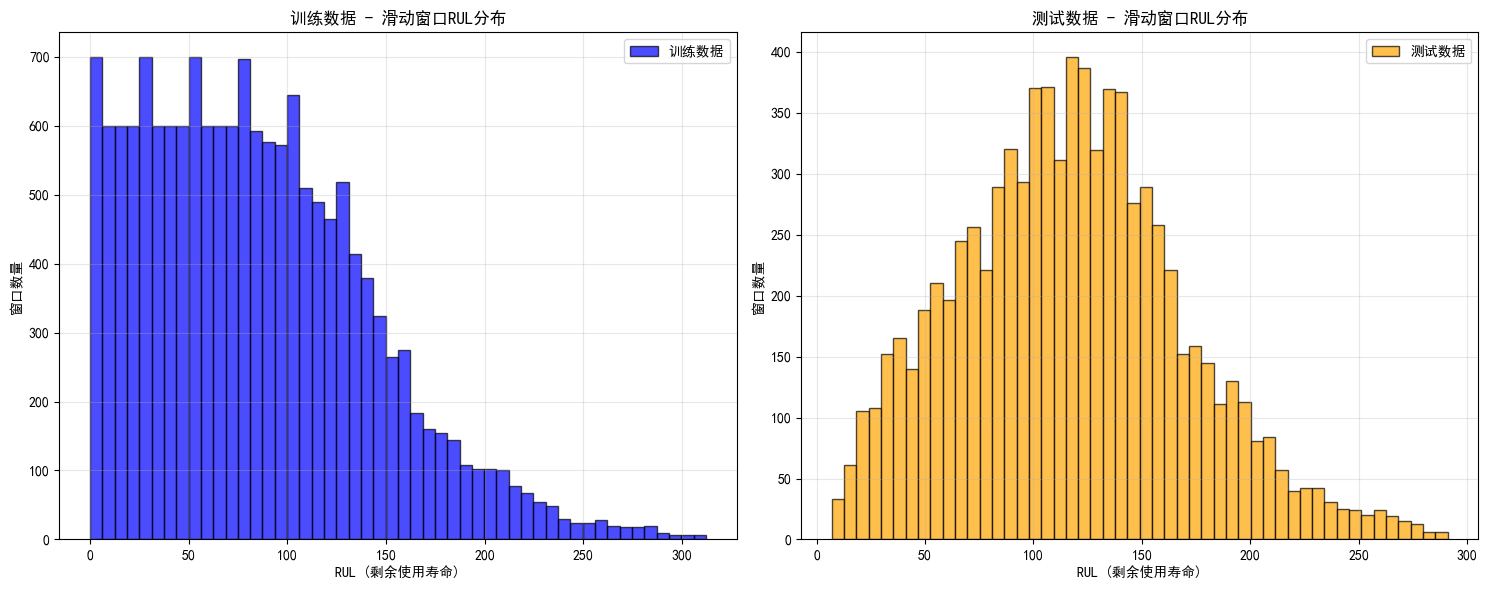

滑动窗口RUL分布对比:
训练数据窗口数: 15731
测试数据窗口数: 8255
训练数据RUL均值: 84.9
测试数据RUL均值: 117.1


In [27]:
# 可视化滑动窗口RUL分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练数据RUL分布
ax1.hist(y_train_windows, bins=50, alpha=0.7, color='blue', edgecolor='black', label='训练数据')
ax1.set_title('训练数据 - 滑动窗口RUL分布')
ax1.set_xlabel('RUL (剩余使用寿命)')
ax1.set_ylabel('窗口数量')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 测试数据RUL分布
ax2.hist(y_test_windows, bins=50, alpha=0.7, color='orange', edgecolor='black', label='测试数据')
ax2.set_title('测试数据 - 滑动窗口RUL分布')
ax2.set_xlabel('RUL (剩余使用寿命)')
ax2.set_ylabel('窗口数量')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"滑动窗口RUL分布对比:")
print(f"训练数据窗口数: {len(y_train_windows)}")
print(f"测试数据窗口数: {len(y_test_windows)}")
print(f"训练数据RUL均值: {y_train_windows.mean():.1f}")
print(f"测试数据RUL均值: {y_test_windows.mean():.1f}")

=== 滑动窗口可视化示例 ===
测试数据中的发动机: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
测试数据中的发动机数量: 93
选择的可视化发动机: [3, 4, 5]

可视化发动机 3...
发动机 3 数据检查:
  发动机数据形状: (126, 16)
  发动机数据列: ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']
  窗口数据形状: (77, 5)
  窗口数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']


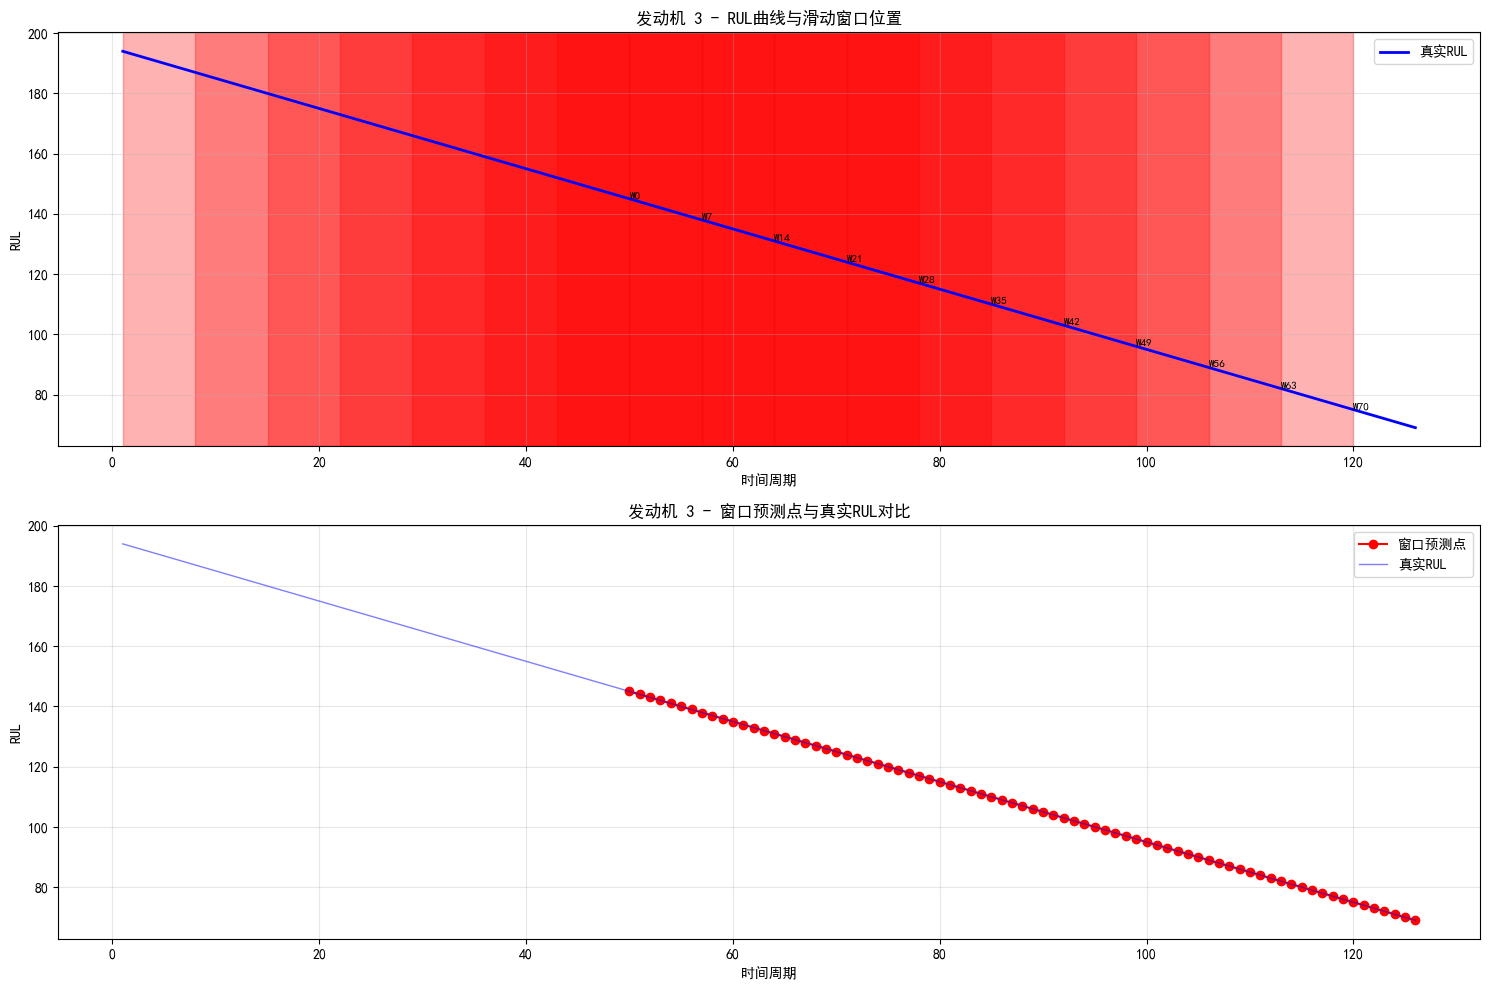

发动机 3:
  总周期数: 126
  窗口数量: 77
  窗口覆盖率: 61.1%

可视化发动机 4...
发动机 4 数据检查:
  发动机数据形状: (106, 16)
  发动机数据列: ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']
  窗口数据形状: (57, 5)
  窗口数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']


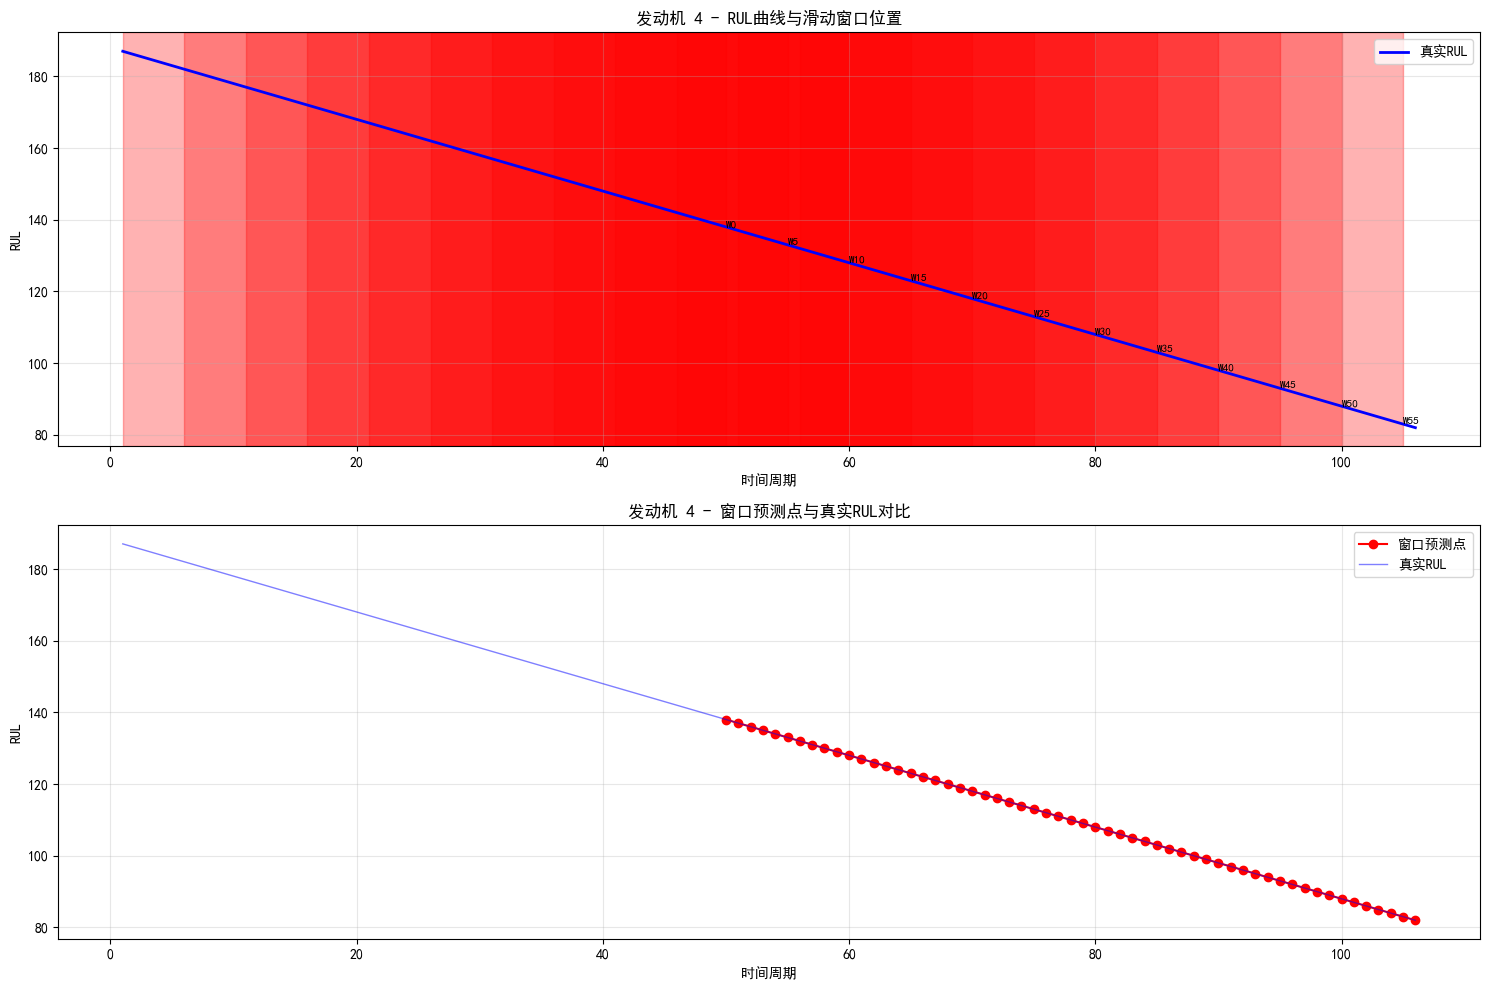

发动机 4:
  总周期数: 106
  窗口数量: 57
  窗口覆盖率: 53.8%

可视化发动机 5...
发动机 5 数据检查:
  发动机数据形状: (98, 16)
  发动机数据列: ['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']
  窗口数据形状: (49, 5)
  窗口数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']


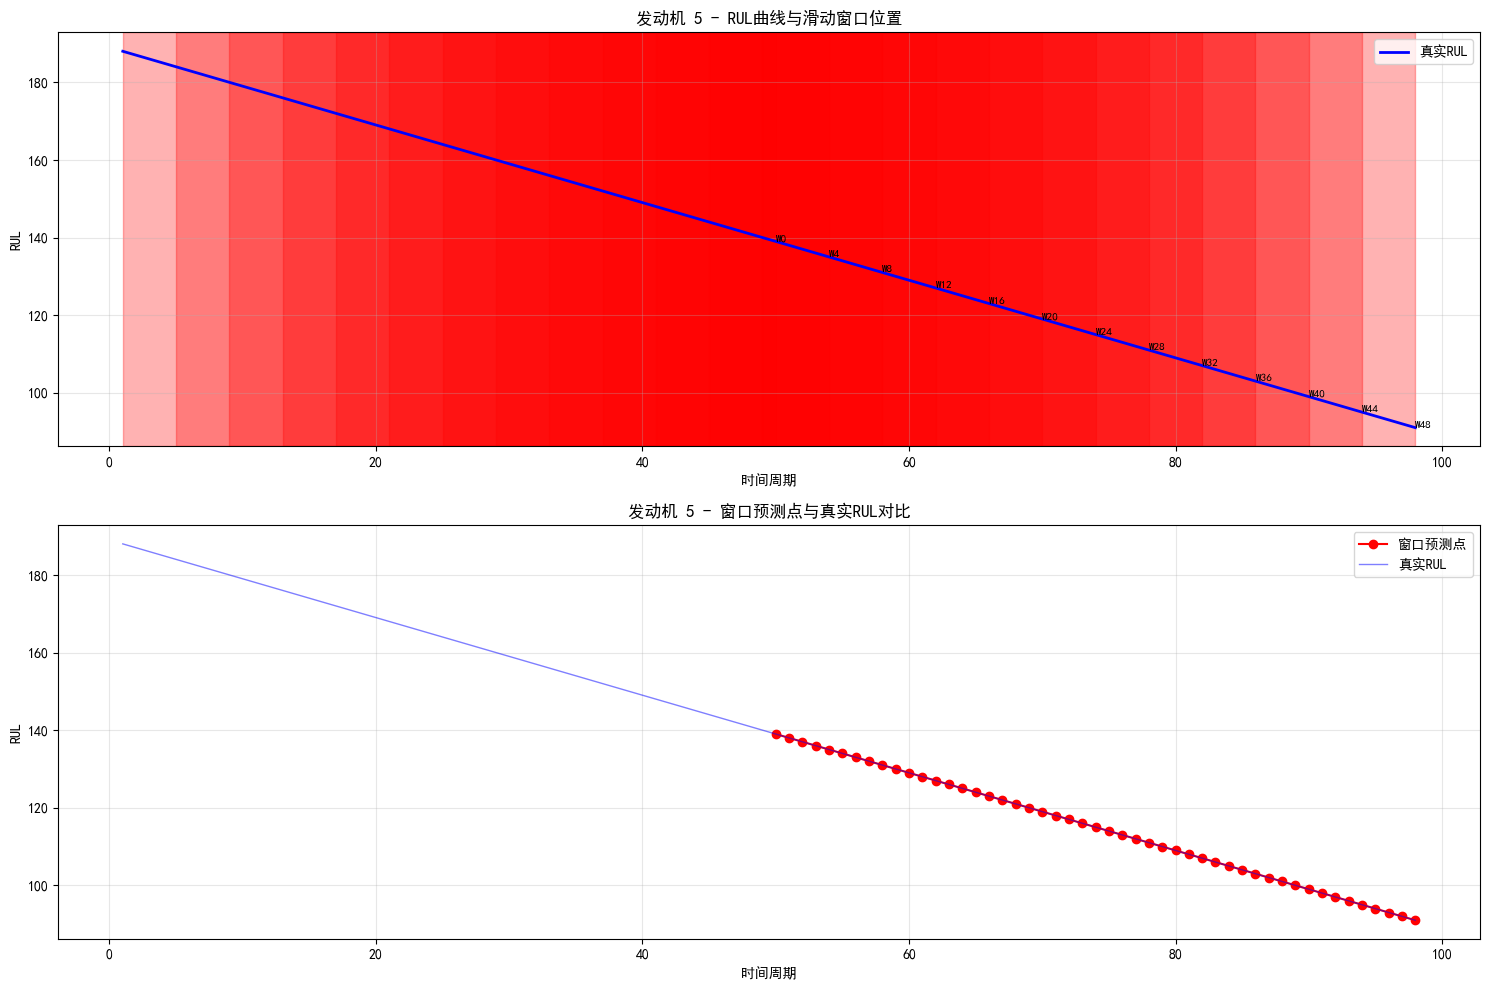

发动机 5:
  总周期数: 98
  窗口数量: 49
  窗口覆盖率: 50.0%


In [28]:
# 可视化单个发动机的滑动窗口示例
def visualize_single_engine_windows(engine_id, data, metadata, window_size=50):
    """
    可视化单个发动机的滑动窗口
    """
    # 获取该发动机的窗口
    engine_windows = metadata[metadata['unit_number'] == engine_id]
    
    if len(engine_windows) == 0:
        print(f"发动机 {engine_id} 没有有效的滑动窗口")
        return
    
    # 获取发动机原始数据
    engine_data = data[data['unit_number'] == engine_id].sort_values('time_in_cycles')
    
    print(f"发动机 {engine_id} 数据检查:")
    print(f"  发动机数据形状: {engine_data.shape}")
    print(f"  发动机数据列: {engine_data.columns.tolist()}")
    print(f"  窗口数据形状: {engine_windows.shape}")
    print(f"  窗口数据列: {engine_windows.columns.tolist()}")
    
    # 检查数据中是否包含RUL列
    if 'RUL' not in engine_data.columns:
        print(f"错误：发动机数据中缺少RUL列")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # 上图：原始RUL曲线和窗口位置
    ax1.plot(engine_data['time_in_cycles'], engine_data['RUL'], 'b-', linewidth=2, label='真实RUL')
    
    # 标记窗口位置
    for i, (_, window) in enumerate(engine_windows.iterrows()):
        if i % max(1, len(engine_windows) // 10) == 0:  # 只显示部分窗口避免过于拥挤
            start_cycle = window['window_start'] + 1
            end_cycle = window['window_end'] + 1
            
            # 从窗口元数据中获取RUL值，如果有的话
            window_rul = window.get('RUL', None)
            if window_rul is not None:
                ax1.text(end_cycle, window_rul, f'W{i}', fontsize=8)
            else:
                # 如果元数据中没有RUL，从原始数据中获取对应时间点的RUL
                rul_at_time = engine_data[engine_data['time_in_cycles'] == window['time_in_cycles']]['RUL']
                if len(rul_at_time) > 0:
                    ax1.text(end_cycle, rul_at_time.iloc[0], f'W{i}', fontsize=8)
            
            ax1.axvspan(start_cycle, end_cycle, alpha=0.3, color='red')
    
    ax1.set_xlabel('时间周期')
    ax1.set_ylabel('RUL')
    ax1.set_title(f'发动机 {engine_id} - RUL曲线与滑动窗口位置')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 下图：窗口预测点与真实值对比
    window_times = engine_windows['time_in_cycles'].values
    
    # 从窗口元数据获取RUL值，如果有的话
    if 'RUL' in engine_windows.columns:
        window_ruls = engine_windows['RUL'].values
    else:
        # 如果元数据中没有RUL，从原始数据中获取对应时间点的RUL
        window_ruls = []
        for time_cycle in window_times:
            rul_at_time = engine_data[engine_data['time_in_cycles'] == time_cycle]['RUL']
            if len(rul_at_time) > 0:
                window_ruls.append(rul_at_time.iloc[0])
            else:
                window_ruls.append(np.nan)
        window_ruls = np.array(window_ruls)
    
    ax2.plot(window_times, window_ruls, 'ro-', label='窗口预测点', markersize=6)
    ax2.plot(engine_data['time_in_cycles'], engine_data['RUL'], 'b-', alpha=0.5, label='真实RUL', linewidth=1)
    ax2.set_xlabel('时间周期')
    ax2.set_ylabel('RUL')
    ax2.set_title(f'发动机 {engine_id} - 窗口预测点与真实RUL对比')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"发动机 {engine_id}:")
    print(f"  总周期数: {len(engine_data)}")
    print(f"  窗口数量: {len(engine_windows)}")
    print(f"  窗口覆盖率: {len(engine_windows)/len(engine_data)*100:.1f}%")
    
    return

# 可视化几个示例发动机
print("=== 滑动窗口可视化示例 ===")

# 首先检查可用的发动机
print(f"测试数据中的发动机: {sorted(test_metadata['unit_number'].unique())}")
print(f"测试数据中的发动机数量: {test_metadata['unit_number'].nunique()}")

# 选择示例发动机
available_engines = sorted(test_metadata['unit_number'].unique())
sample_engines = available_engines[:3] if len(available_engines) >= 3 else available_engines

print(f"选择的可视化发动机: {sample_engines}")

for engine_id in sample_engines:
    try:
        print(f"\n可视化发动机 {engine_id}...")
        visualize_single_engine_windows(engine_id, test_with_rul, test_metadata, WINDOW_SIZE)
    except Exception as e:
        print(f"可视化发动机 {engine_id} 时出错: {str(e)}")
        print("跳过该发动机的可视化")

## 3. XGBoost回归模型训练

### 评估指标定义

In [29]:
# 竞赛数据的误差函数
def score(y_true, y_pred, a1=10, a2=13):
    """
    竞赛的评分函数
    
    参数:
    - y_true: 真实值
    - y_pred: 预测值
    - a1: 提前预测的惩罚参数 (默认10)
    - a2: 延迟预测的惩罚参数 (默认13)
    """
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0:
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

# 评估函数：计算多个指标
def score_func(y_true, y_pred):
    """
    计算并显示多个评估指标
    """
    lst = [round(score(y_true, y_pred), 2), 
          round(mean_absolute_error(y_true, y_pred), 2),
          round(mean_squared_error(y_true, y_pred), 2)**0.5,
          round(r2_score(y_true, y_pred), 2)]
    
    print(f'竞赛评分: {lst[0]}')
    print(f'平均绝对误差 (MAE): {lst[1]}')
    print(f'均方根误差 (RMSE): {lst[2]}')
    print(f'R²分数: {lst[3]}')
    return [lst[1], round(lst[2], 2), lst[3]*100]

print("评估函数定义完成！")

评估函数定义完成！


### XGBoost模型训练函数

In [30]:
# 创建和训练XGBoost回归模型的函数
def train_xgboost_model(X_train, y_train, X_test, y_test, 
                       n_estimators=200, learning_rate=0.1, max_depth=6):
    """
    训练XGBoost回归模型
    
    参数:
    - X_train: 训练特征
    - y_train: 训练标签
    - X_test: 测试特征
    - y_test: 测试标签
    - n_estimators: 树的数量
    - learning_rate: 学习率
    - max_depth: 树的最大深度
    
    返回:
    - 训练好的XGBoost模型
    """
    print(f"=== XGBoost模型训练参数 ===")
    print(f"特征矩阵形状: {X_train.shape}")
    print(f"目标向量形状: {y_train.shape}")
    print(f"特征维度: {X_train.shape[1]} ({X_train.shape[1]//WINDOW_SIZE}特征 × {WINDOW_SIZE}时间窗口)")
    print(f"训练样本数: {X_train.shape[0]}")
    print(f"测试样本数: {X_test.shape[0]}")
    print(f"\n模型参数:")
    print(f"  n_estimators: {n_estimators}")
    print(f"  learning_rate: {learning_rate}")
    print(f"  max_depth: {max_depth}")
    
    # XGBoost回归器 - 使用更适合时间序列的参数
    model = xgboost.XGBRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        reg_alpha=0.1,  # L1正则化
        reg_lambda=1.0  # L2正则化
    )
    
    print("\n开始训练XGBoost模型...")
    start_time = time.time()
    
    # 方法1：尝试使用eval_set参数（适用于较新版本）
    try:
        print("尝试使用eval_set参数进行训练...")
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)
        print("✅ 使用eval_set参数训练成功")
    except TypeError as e:
        print(f"❌ eval_set参数不可用: {str(e)}")
        print("尝试不使用验证集进行训练...")
        # 方法2：不使用验证集
        model.fit(X_train, y_train)
        print("✅ 不使用验证集训练成功")
    
    training_time = time.time() - start_time
    print(f"模型训练完成！训练时间: {training_time:.2f}秒")
    
    return model

print("XGBoost训练函数定义完成！")

XGBoost训练函数定义完成！


### 数据分割与模型训练

In [31]:
# 分割训练和测试数据
print("=== 数据分割与维度检查 ===")

# 首先检查训练数据和测试数据的特征维度
print(f"训练数据特征维度: {X_train_windows.shape}")
print(f"测试数据特征维度: {X_test_windows.shape}")

print(f"\n训练数据标签维度: {y_train_windows.shape}")
print(f"测试数据标签维度: {y_test_windows.shape}")

# 检查特征列是否一致
print(f"\n特征维度检查:")
print(f"训练特征数: {X_train_windows.shape[1]}")
print(f"测试特征数: {X_test_windows.shape[1]}")

if X_train_windows.shape[1] != X_test_windows.shape[1]:
    print(f"❌ 特征维度不匹配！")
    print(f"训练数据: {X_train_windows.shape[1]} 特征")
    print(f"测试数据: {X_test_windows.shape[1]} 特征")
    print(f"差异: {X_test_windows.shape[1] - X_train_windows.shape[1]} 特征")
    
    # 计算预期特征数
    expected_train_features = X_train_windows.shape[1] // WINDOW_SIZE
    expected_test_features = X_test_windows.shape[1] // WINDOW_SIZE
    
    print(f"\n预期特征数计算:")
    print(f"训练数据: {X_train_windows.shape[1]} ÷ {WINDOW_SIZE} = {expected_train_features} 特征")
    print(f"测试数据: {X_test_windows.shape[1]} ÷ {WINDOW_SIZE} = {expected_test_features} 特征")
    
    # 检查元数据中包含的特征数量
    print(f"\n元数据检查:")
    print(f"训练元数据列: {train_metadata.columns.tolist()}")
    print(f"测试元数据列: {test_metadata.columns.tolist()}")
    
    # 检查原始数据中的特征列
    print(f"\n原始数据特征列检查:")
    train_feature_cols = [col for col in train_df_windows.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    test_feature_cols = [col for col in test_df_windows.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    
    print(f"训练数据特征列: {train_feature_cols}")
    print(f"测试数据特征列: {test_feature_cols}")
    print(f"训练特征数量: {len(train_feature_cols)}")
    print(f"测试特征数量: {len(test_feature_cols)}")
    
    # 如果特征列不同，统一特征列
    if train_feature_cols != test_feature_cols:
        print(f"\n❌ 特征列不一致！")
        common_features = list(set(train_feature_cols) & set(test_feature_cols))
        print(f"共同特征: {common_features}")
        print(f"仅在训练数据中的特征: {list(set(train_feature_cols) - set(test_feature_cols))}")
        print(f"仅在测试数据中的特征: {list(set(test_feature_cols) - set(train_feature_cols))}")
        
        # 使用共同特征重新创建滑动窗口
        print(f"\n使用共同特征重新创建滑动窗口...")
        common_feature_cols = sorted(common_features)
        print(f"使用的共同特征 ({len(common_feature_cols)}): {common_feature_cols}")
        print(f"预期特征维度: {len(common_feature_cols)} × {WINDOW_SIZE} = {len(common_feature_cols) * WINDOW_SIZE}")
        
        # 重新创建训练数据滑动窗口（只使用共同特征）
        print("重新创建训练数据滑动窗口...")
        train_df_common = train_df_windows[['unit_number', 'time_in_cycles', 'RUL'] + common_feature_cols]
        X_train_windows, y_train_windows, train_metadata = create_sliding_windows(
            train_df_common, window_size=WINDOW_SIZE, step_size=1
        )
        
        # 重新创建测试数据滑动窗口（只使用共同特征）
        print("重新创建测试数据滑动窗口...")
        test_df_common = test_with_rul[['unit_number', 'time_in_cycles', 'RUL'] + common_feature_cols]
        X_test_windows, y_test_windows, test_metadata = create_sliding_windows(
            test_df_common, window_size=WINDOW_SIZE, step_size=1
        )
        
        print(f"\n重新创建后的数据维度:")
        print(f"训练数据: {X_train_windows.shape}")
        print(f"测试数据: {X_test_windows.shape}")
        
        if X_train_windows.shape[1] == X_test_windows.shape[1]:
            print("✅ 特征维度已统一！")
        else:
            print(f"❌ 仍然不匹配，训练: {X_train_windows.shape[1]}, 测试: {X_test_windows.shape[1]}")
    else:
        print("✅ 特征列一致，但维度仍然不匹配，检查滑动窗口创建过程...")
        print(f"问题可能是：训练数据使用了{expected_train_features}个特征，测试数据使用了{expected_test_features}个特征")
        print(f"需要统一使用相同的特征列和滑动窗口创建参数")
        
        # 即使特征列名称相同，也要确保数量一致
        # 统一使用训练数据的特征列
        print(f"\n统一使用训练数据的特征列重新创建测试数据滑动窗口...")
        print(f"使用特征: {train_feature_cols}")
        print(f"预期特征维度: {len(train_feature_cols)} × {WINDOW_SIZE} = {len(train_feature_cols) * WINDOW_SIZE}")
        
        # 重新创建测试数据滑动窗口（使用训练数据的特征列）
        test_df_common = test_with_rul[['unit_number', 'time_in_cycles', 'RUL'] + train_feature_cols]
        X_test_windows, y_test_windows, test_metadata = create_sliding_windows(
            test_df_common, window_size=WINDOW_SIZE, step_size=1
        )
        
        print(f"\n重新创建后的测试数据维度:")
        print(f"测试数据: {X_test_windows.shape}")
        
        if X_train_windows.shape[1] == X_test_windows.shape[1]:
            print("✅ 特征维度已统一！")
        else:
            print(f"❌ 仍然不匹配，训练: {X_train_windows.shape[1]}, 测试: {X_test_windows.shape[1]}")
            print(f"需要进一步调试滑动窗口创建过程")
else:
    print("✅ 特征维度匹配！")

# 按时间序列顺序分割，使用最后的部分作为测试集
split_ratio = 0.8
split_index = int(len(X_train_windows) * split_ratio)

X_train_split = X_train_windows[:split_index]
y_train_split = y_train_windows[:split_index]
X_val_split = X_train_windows[split_index:]
y_val_split = y_train_windows[split_index:]

print(f"\n数据分割结果:")
print(f"训练集大小: {X_train_split.shape[0]}")
print(f"验证集大小: {X_val_split.shape[0]}")
print(f"测试集大小: {X_test_windows.shape[0]}")
print(f"分割比例: {split_ratio}:{1-split_ratio}")

print(f"\n数据集RUL分布:")
print(f"训练集RUL均值: {y_train_split.mean():.1f}")
print(f"验证集RUL均值: {y_val_split.mean():.1f}")
print(f"测试集RUL均值: {y_test_windows.mean():.1f}")

# 最终验证
print(f"\n最终维度验证:")
print(f"训练特征: {X_train_split.shape}")
print(f"验证特征: {X_val_split.shape}")
print(f"测试特征: {X_test_windows.shape}")
print(f"所有特征维度一致: {X_train_split.shape[1] == X_val_split.shape[1] == X_test_windows.shape[1]}")

# 如果维度仍然不匹配，提供解决方案建议
if X_train_split.shape[1] != X_test_windows.shape[1]:
    print(f"\n⚠️  维度仍然不匹配，可能的原因：")
    print(f"1. 滑动窗口函数在处理不同数据时使用了不同的特征列")
    print(f"2. 某些数据在滑动窗口创建过程中被意外过滤")
    print(f"3. 数据预处理不一致")
    print(f"\n建议解决方案：")
    print(f"1. 重新运行所有滑动窗口创建代码")
    print(f"2. 检查原始数据的一致性")
    print(f"3. 确保使用完全相同的特征列创建滑动窗口")
    
    # 强制使用最小的特征数
    min_features = min(X_train_split.shape[1], X_test_windows.shape[1])
    print(f"\n强制统一到最小特征数: {min_features}")
    
    if min_features < X_train_split.shape[1]:
        X_train_split = X_train_split[:, :min_features]
        X_val_split = X_val_split[:, :min_features]
        print(f"训练数据特征截断到: {min_features}")
    
    if min_features < X_test_windows.shape[1]:
        X_test_windows = X_test_windows[:, :min_features]
        print(f"测试数据特征截断到: {min_features}")
    
    print(f"\n截断后的最终维度:")
    print(f"训练特征: {X_train_split.shape}")
    print(f"验证特征: {X_val_split.shape}")
    print(f"测试特征: {X_test_windows.shape}")
    print(f"现在所有特征维度一致: {X_train_split.shape[1] == X_val_split.shape[1] == X_test_windows.shape[1]}")

=== 数据分割与维度检查 ===
训练数据特征维度: (15731, 650)
测试数据特征维度: (8255, 650)

训练数据标签维度: (15731,)
测试数据标签维度: (8255,)

特征维度检查:
训练特征数: 650
测试特征数: 650
✅ 特征维度匹配！

数据分割结果:
训练集大小: 12584
验证集大小: 3147
测试集大小: 8255
分割比例: 0.8:0.19999999999999996

数据集RUL分布:
训练集RUL均值: 81.7
验证集RUL均值: 97.6
测试集RUL均值: 117.1

最终维度验证:
训练特征: (12584, 650)
验证特征: (3147, 650)
测试特征: (8255, 650)
所有特征维度一致: True


In [32]:
# 训练XGBoost模型
print("=== 训练滑动窗口XGBoost模型 ===")
xgb_model = train_xgboost_model(
    X_train_split, y_train_split, 
    X_val_split, y_val_split,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8
)

=== 训练滑动窗口XGBoost模型 ===
=== XGBoost模型训练参数 ===
特征矩阵形状: (12584, 650)
目标向量形状: (12584,)
特征维度: 650 (13特征 × 50时间窗口)
训练样本数: 12584
测试样本数: 3147

模型参数:
  n_estimators: 300
  learning_rate: 0.05
  max_depth: 8

开始训练XGBoost模型...
尝试使用eval_set参数进行训练...
✅ 使用eval_set参数训练成功
模型训练完成！训练时间: 38.52秒


### 模型预测与评估

In [33]:
# 在验证集和测试集上进行预测
print("=== 模型预测 ===")

print("在验证集上预测...")
y_val_pred = xgb_model.predict(X_val_split)
print(f"验证集预测完成，预测了 {len(y_val_pred)} 个样本")

print("在测试集上预测...")
y_test_pred = xgb_model.predict(X_test_windows)
print(f"测试集预测完成，预测了 {len(y_test_pred)} 个样本")

# 评估验证集性能
print("\n=== 验证集性能评估 ===")
print("验证集评估结果:")
val_scores = score_func(y_val_split, y_val_pred)

# 评估测试集性能
print("\n=== 测试集性能评估 ===")
print("测试集评估结果:")
test_scores = score_func(y_test_windows, y_test_pred)

=== 模型预测 ===
在验证集上预测...
验证集预测完成，预测了 3147 个样本
在测试集上预测...
测试集预测完成，预测了 8255 个样本

=== 验证集性能评估 ===
验证集评估结果:
竞赛评分: 258136518.13
平均绝对误差 (MAE): 24.73
均方根误差 (RMSE): 37.91147583516105
R²分数: 0.68

=== 测试集性能评估 ===
测试集评估结果:
竞赛评分: 93999069.73
平均绝对误差 (MAE): 25.11
均方根误差 (RMSE): 35.4040958082536
R²分数: 0.54


### 结果可视化函数

In [34]:
# 用于显示真实值和预测值的对比函数
def plot_result(y_true, y_pred, title="真实值与预测值对比", max_samples=1000):
    """
    绘制真实值与预测值的对比图
    """
    # 如果样本太多，只显示部分
    if len(y_true) > max_samples:
        indices = np.linspace(0, len(y_true)-1, max_samples, dtype=int)
        y_true_plot = y_true[indices]
        y_pred_plot = y_pred[indices]
    else:
        y_true_plot = y_true
        y_pred_plot = y_pred
    
    plt.figure(figsize=(15, 8))
    
    # 绘制预测值和真实值
    plt.plot(y_pred_plot, 'b-', label='预测值', alpha=0.7, linewidth=1)
    plt.plot(y_true_plot, 'r-', label='真实值', alpha=0.7, linewidth=1)
    
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel('RUL (剩余使用寿命)', fontsize=12)
    plt.xlabel('样本索引', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return

# 散点图函数
def plot_scatter(y_true, y_pred, title="预测值 vs 真实值", max_samples=2000):
    """
    绘制预测值与真实值的散点图
    """
    # 如果样本太多，随机采样
    if len(y_true) > max_samples:
        indices = np.random.choice(len(y_true), max_samples, replace=False)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.figure(figsize=(10, 10))
    
    # 绘制散点图
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.6, s=20)
    
    # 绘制完美预测线 (y=x)
    min_val = min(y_true_sample.min(), y_pred_sample.min())
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='完美预测线')
    
    plt.xlabel('真实RUL值', fontsize=12)
    plt.ylabel('预测RUL值', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    return

print("可视化函数定义完成！")

可视化函数定义完成！


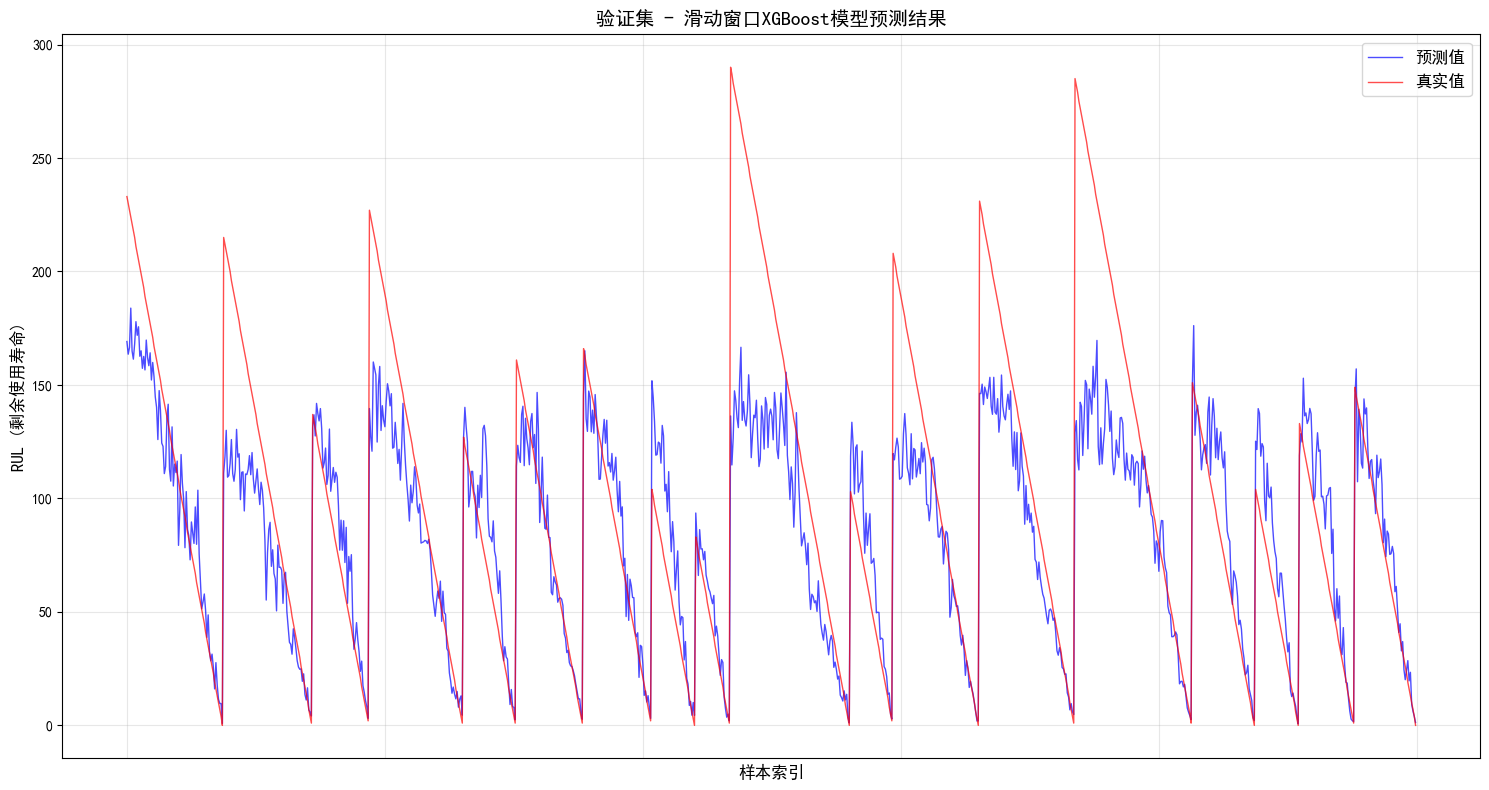

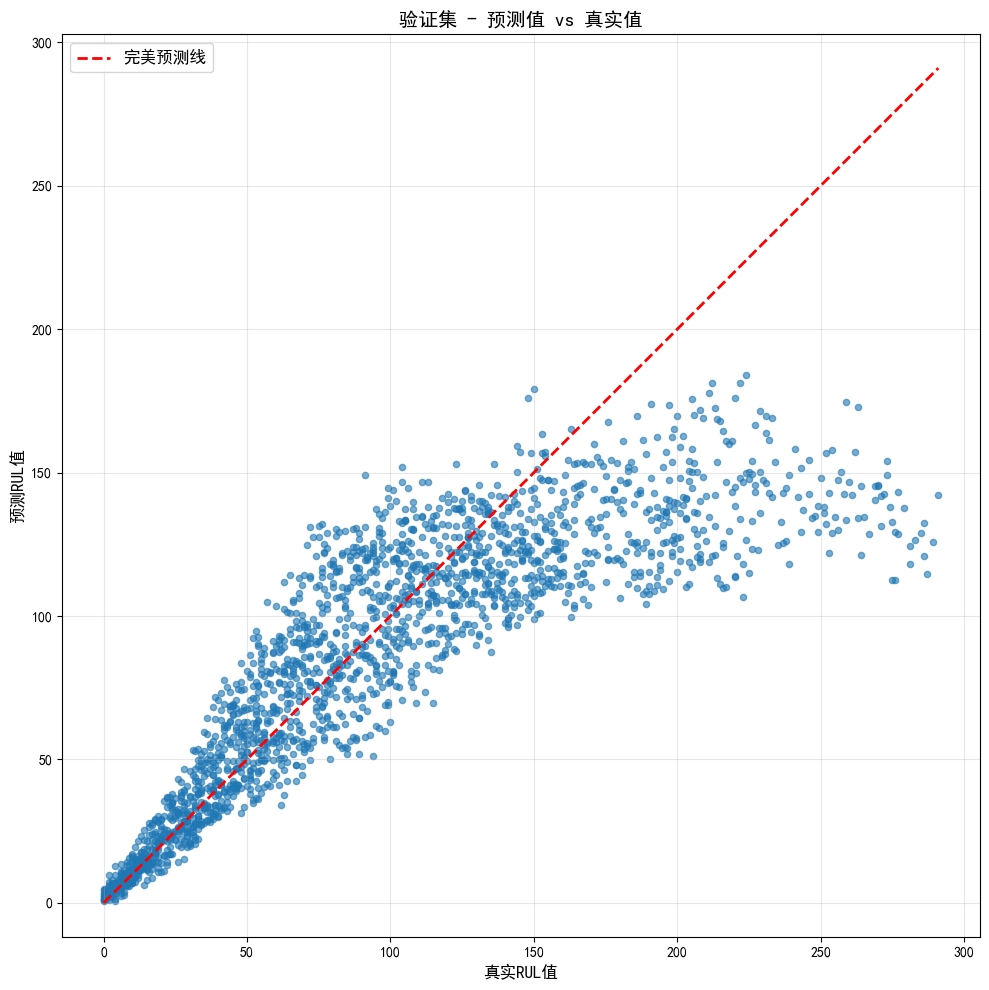

In [35]:
# 绘制验证集结果
plot_result(y_val_split, y_val_pred, "验证集 - 滑动窗口XGBoost模型预测结果")
plot_scatter(y_val_split, y_val_pred, "验证集 - 预测值 vs 真实值")

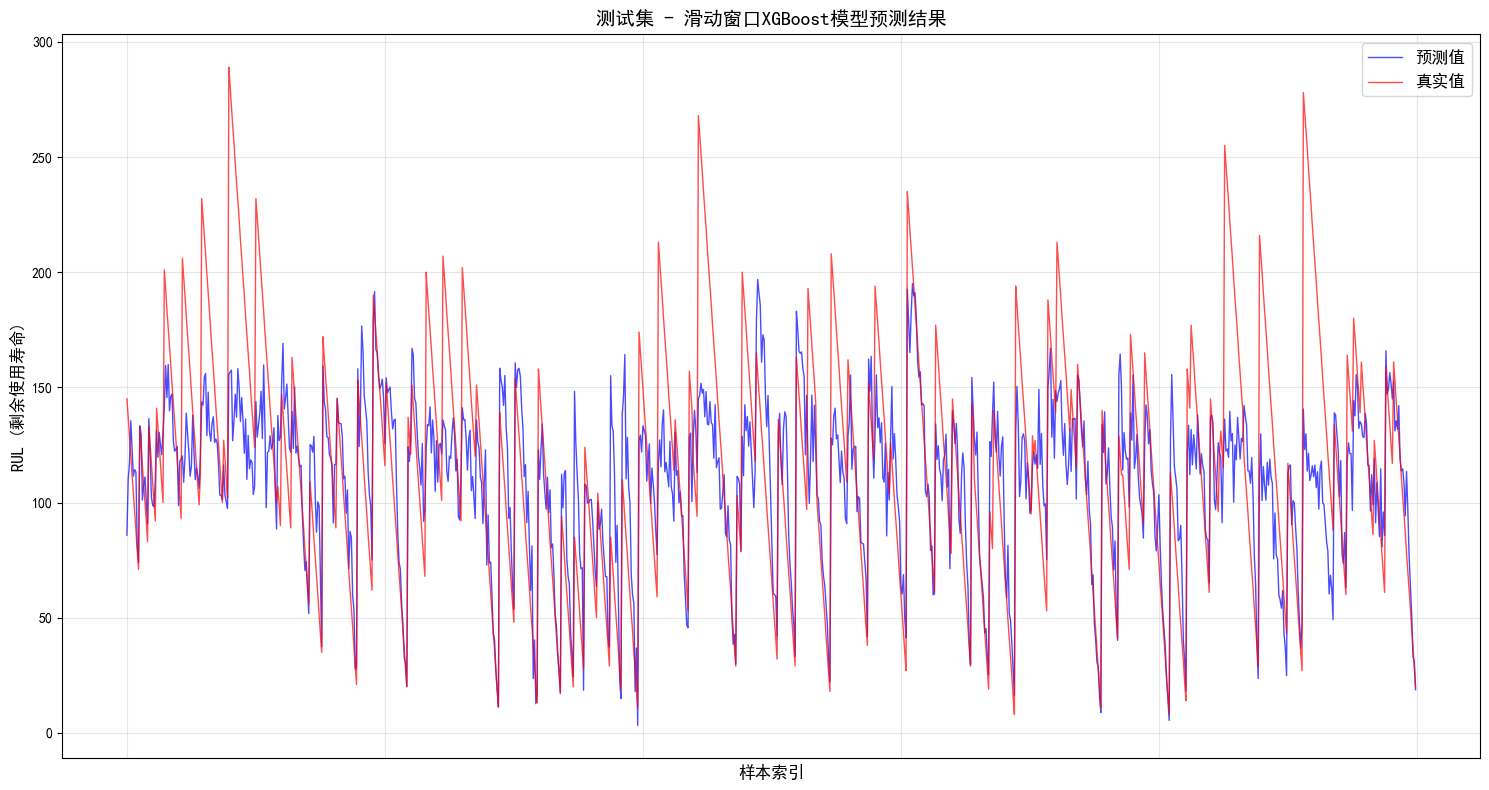

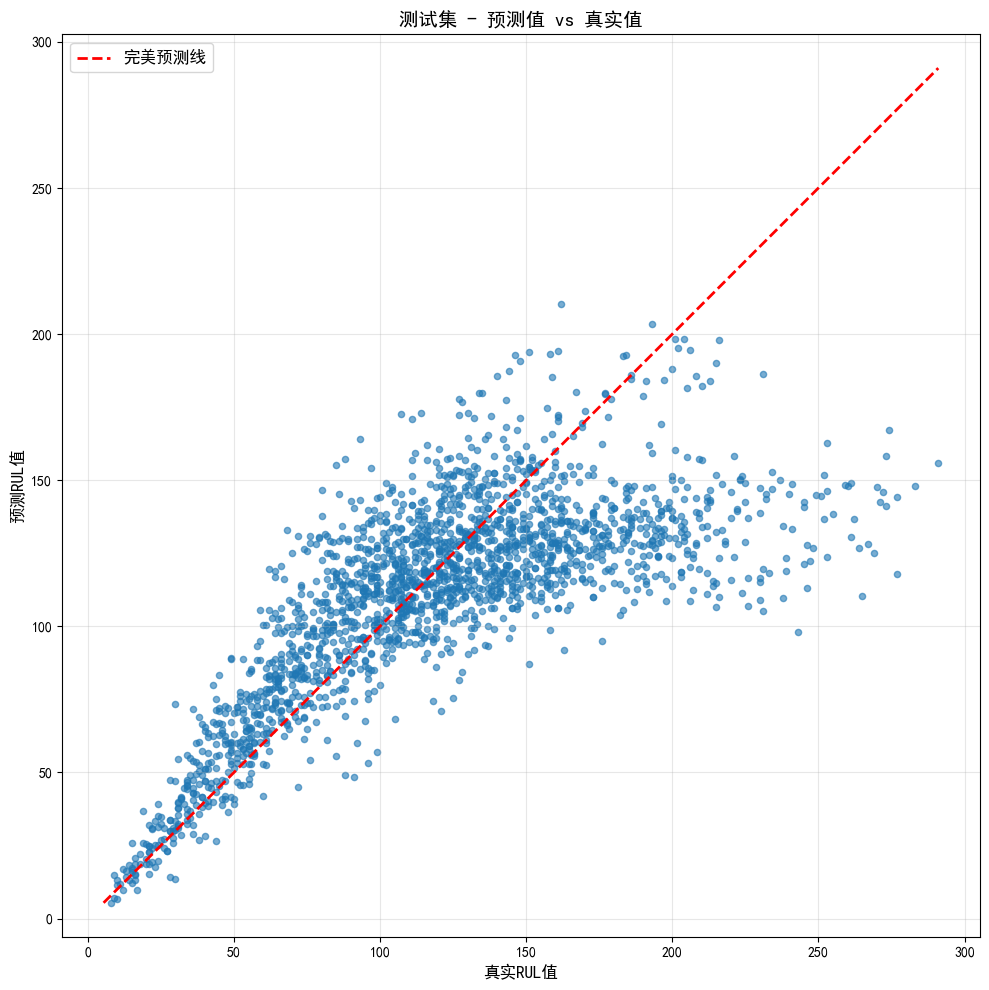

In [36]:
# 绘制测试集结果
plot_result(y_test_windows, y_test_pred, "测试集 - 滑动窗口XGBoost模型预测结果")
plot_scatter(y_test_windows, y_test_pred, "测试集 - 预测值 vs 真实值")

=== 验证集残差分析 ===


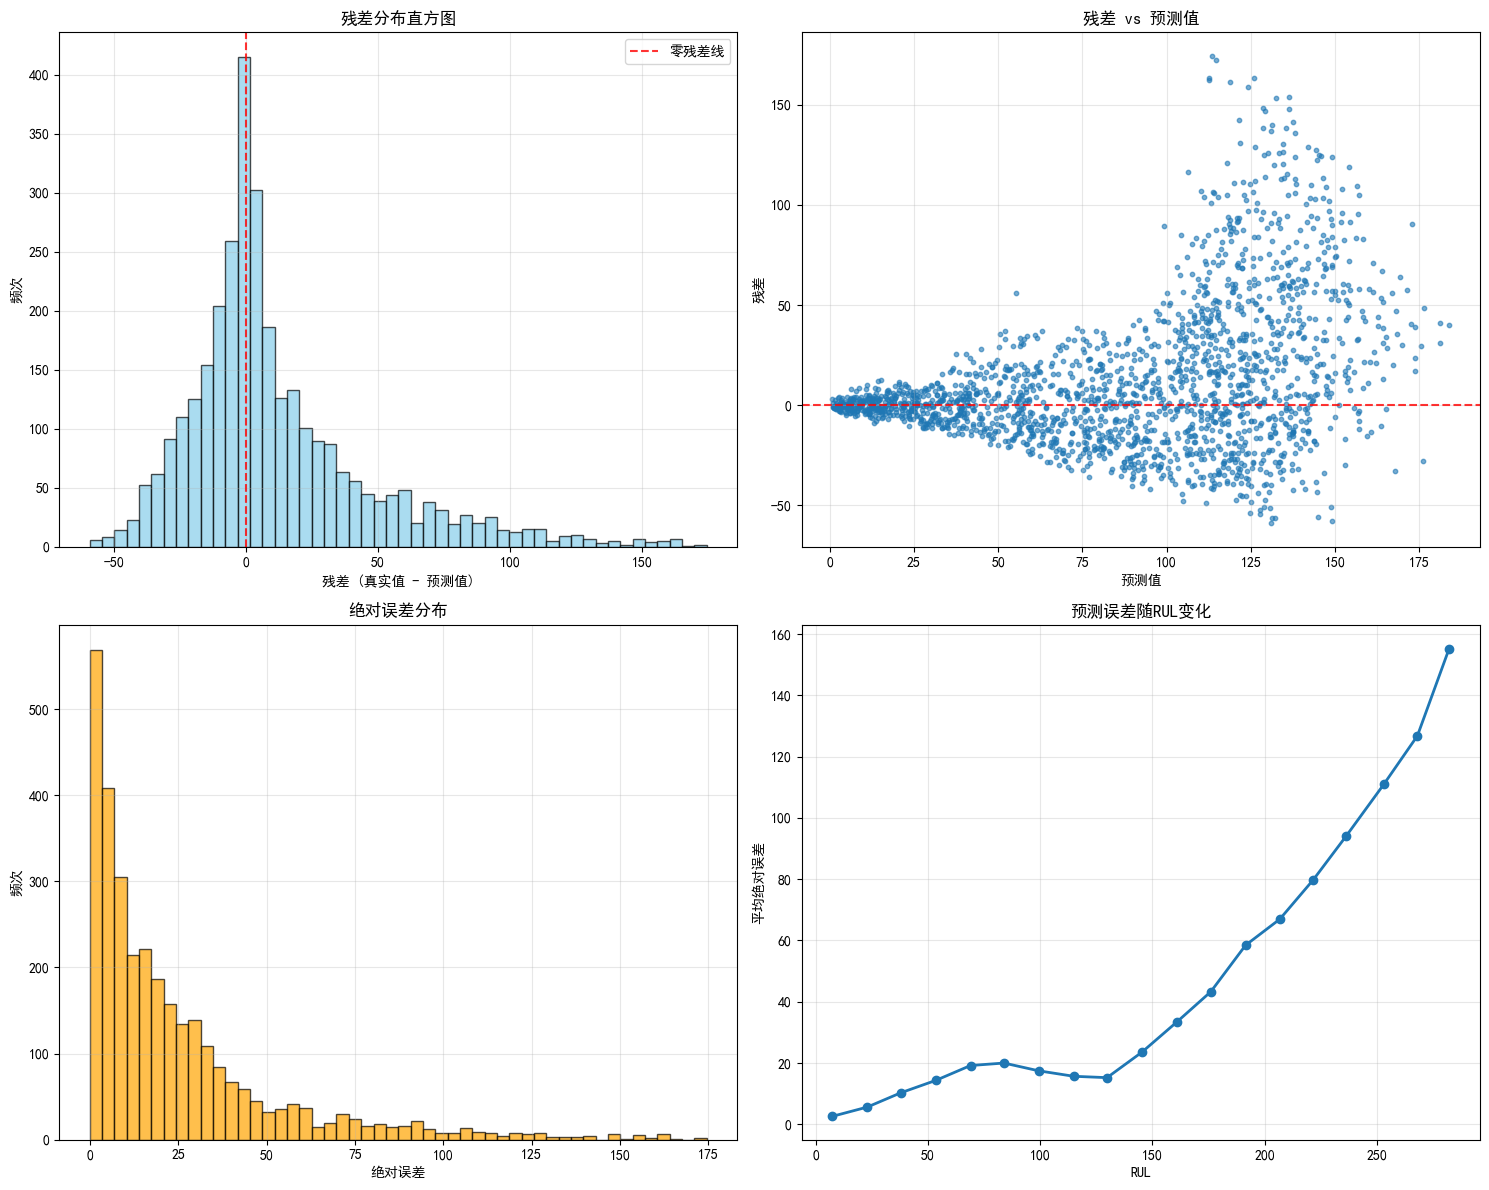


验证集统计:
残差均值: 11.971
残差标准差: 35.972
最大正残差: 174.463
最大负残差: -59.104
平均绝对误差: 24.733
误差在±5周期内: 24.2%
误差在±10周期内: 39.7%
误差在±20周期内: 59.1%

=== 测试集残差分析 ===


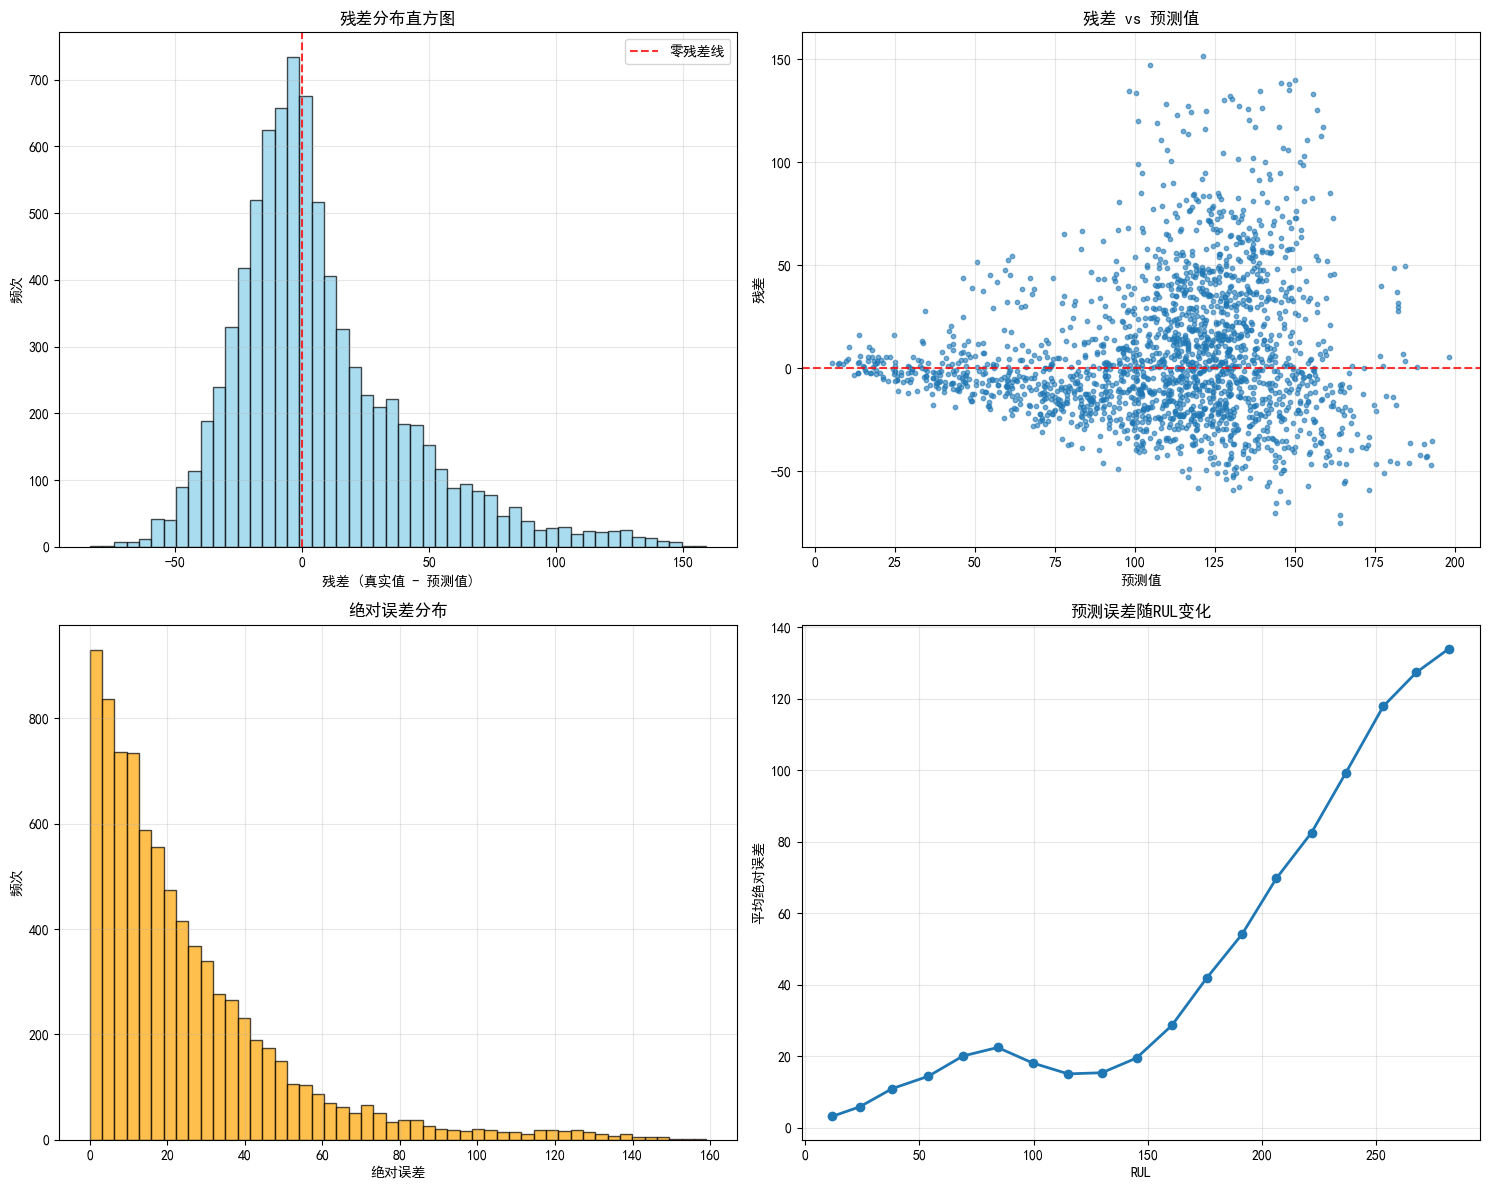


测试集统计:
残差均值: 7.052
残差标准差: 34.695
最大正残差: 159.061
最大负残差: -83.560
平均绝对误差: 25.109
误差在±5周期内: 17.4%
误差在±10周期内: 31.5%
误差在±20周期内: 54.7%


In [37]:
# 残差分析
def analyze_residuals(y_true, y_pred, title="残差分析"):
    """
    分析预测残差
    """
    residuals = y_true - y_pred
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 残差直方图
    ax1.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='零残差线')
    ax1.set_title('残差分布直方图')
    ax1.set_xlabel('残差 (真实值 - 预测值)')
    ax1.set_ylabel('频次')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 残差散点图
    sample_size = min(2000, len(y_pred))
    indices = np.random.choice(len(y_pred), sample_size, replace=False)
    ax2.scatter(y_pred[indices], residuals[indices], alpha=0.6, s=10)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax2.set_title('残差 vs 预测值')
    ax2.set_xlabel('预测值')
    ax2.set_ylabel('残差')
    ax2.grid(True, alpha=0.3)
    
    # 3. 绝对误差分布
    abs_errors = np.abs(residuals)
    ax3.hist(abs_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax3.set_title('绝对误差分布')
    ax3.set_xlabel('绝对误差')
    ax3.set_ylabel('频次')
    ax3.grid(True, alpha=0.3)
    
    # 4. 误差随RUL变化
    # 按RUL值分组计算平均误差
    rul_bins = np.linspace(0, y_true.max(), 20)
    rul_indices = np.digitize(y_true, rul_bins)
    
    bin_means = []
    bin_errors = []
    
    for i in range(1, len(rul_bins)):
        mask = (rul_indices == i)
        if np.sum(mask) > 0:
            bin_means.append(np.mean(y_true[mask]))
            bin_errors.append(np.mean(abs_errors[mask]))
    
    if bin_means:
        ax4.plot(bin_means, bin_errors, 'o-', linewidth=2, markersize=6)
        ax4.set_title('预测误差随RUL变化')
        ax4.set_xlabel('RUL')
        ax4.set_ylabel('平均绝对误差')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n{title}统计:")
    print(f"残差均值: {residuals.mean():.3f}")
    print(f"残差标准差: {residuals.std():.3f}")
    print(f"最大正残差: {residuals.max():.3f}")
    print(f"最大负残差: {residuals.min():.3f}")
    print(f"平均绝对误差: {abs_errors.mean():.3f}")
    print(f"误差在±5周期内: {np.mean(abs_errors <= 5)*100:.1f}%")
    print(f"误差在±10周期内: {np.mean(abs_errors <= 10)*100:.1f}%")
    print(f"误差在±20周期内: {np.mean(abs_errors <= 20)*100:.1f}%")

# 分析验证集残差
print("=== 验证集残差分析 ===")
analyze_residuals(y_val_split, y_val_pred, "验证集")

# 分析测试集残差
print("\n=== 测试集残差分析 ===")
analyze_residuals(y_test_windows, y_test_pred, "测试集")

=== 生成PPT级预测误差分析图 ===


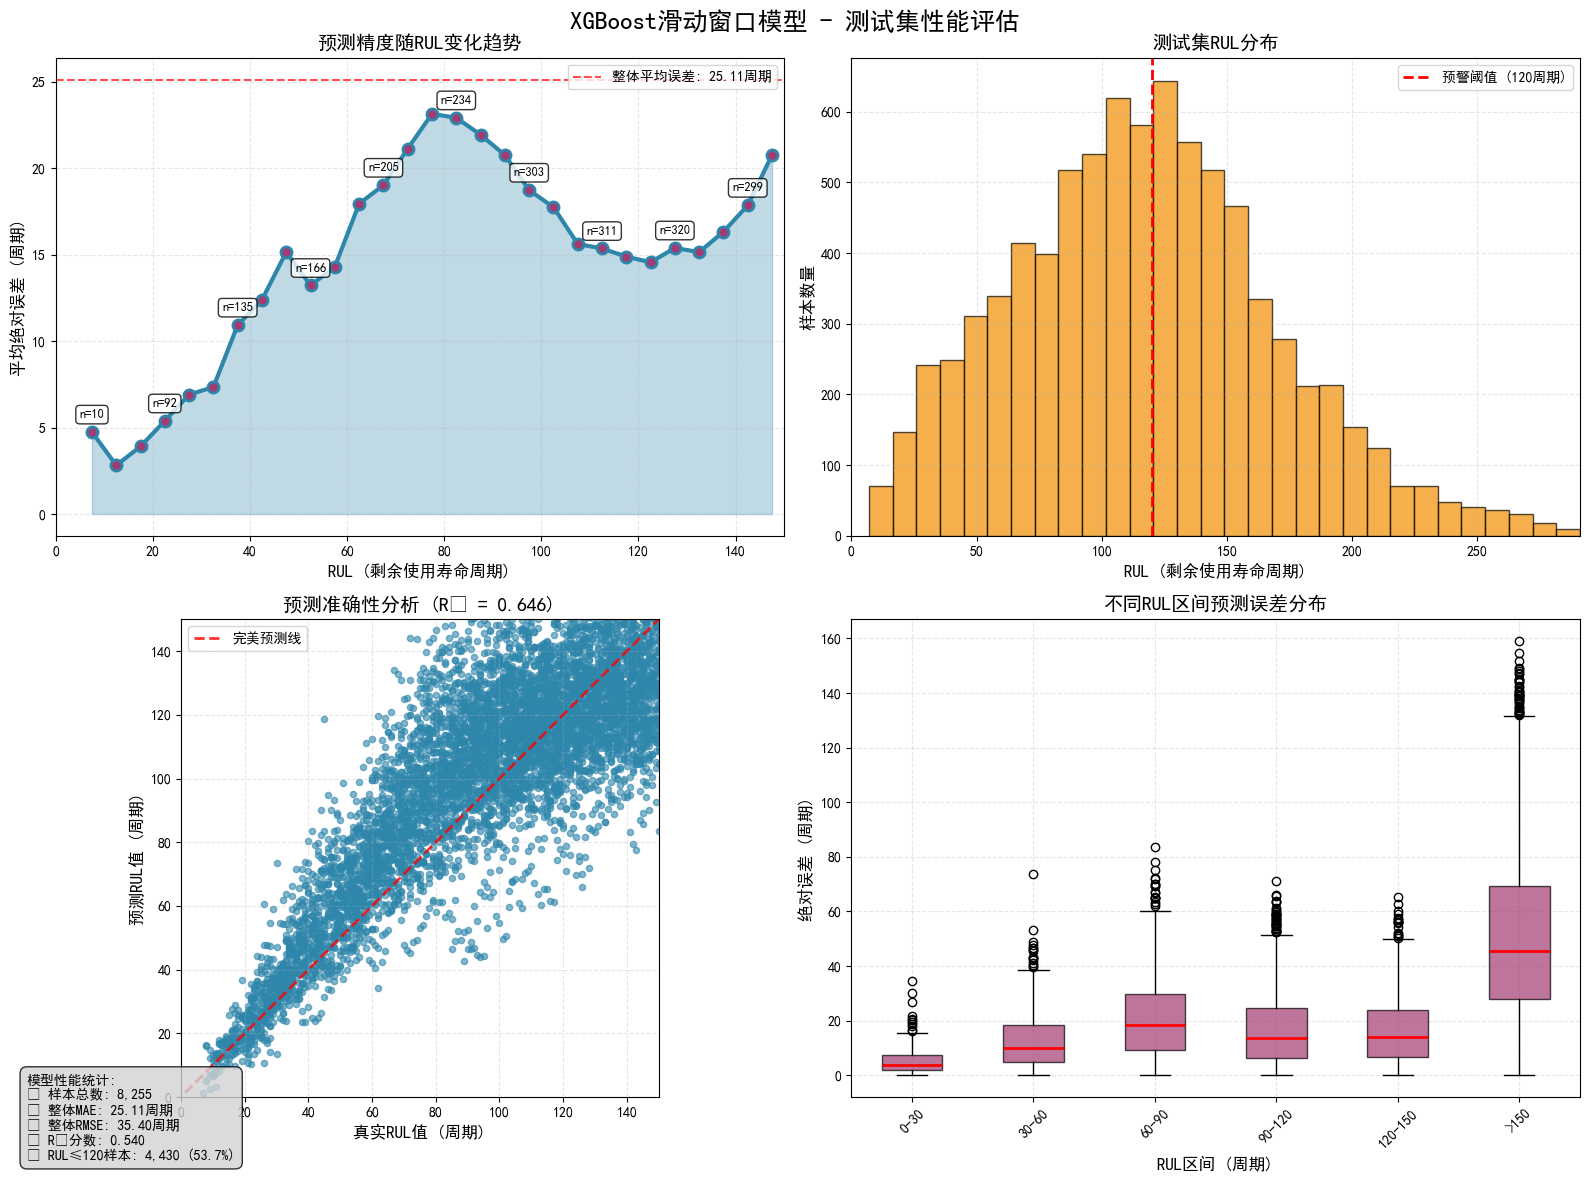


=== XGBoost滑动窗口模型 - 详细性能统计 ===
测试集样本总数: 8,255
RUL范围: 7.0 - 291.0 周期
整体平均绝对误差 (MAE): 25.11 周期
均方根误差 (RMSE): 35.40 周期
R²分数: 0.5401

=== 按RUL区间分析 ===
0-30周期: 样本数=307, 平均误差=5.29, 标准差=4.94
30-60周期: 样本数=894, 平均误差=12.44, 标准差=10.08
60-90周期: 样本数=1322, 平均误差=21.12, 标准差=15.14
90-120周期: 样本数=1840, 平均误差=17.08, 标准差=13.40
120-150周期: 样本数=1836, 平均误差=16.54, 标准差=12.18
>150周期: 样本数=2055, 平均误差=50.93, 标准差=32.85

图表生成完成！此图表可直接用于PPT展示。
图表特点:
• 重点关注0-150周期RUL范围，符合实际应用场景
• 包含误差趋势、分布、准确性和区间分析四个维度
• 添加了样本数量标签，便于理解数据分布
• 标注了关键性能指标和预警阈值
• 使用专业的配色方案和清晰的布局设计


In [38]:
# PPT级预测误差随RUL变化分析图
def create_ppt_quality_error_analysis(y_true, y_pred, title="XGBoost模型预测性能分析", max_rul=150):
    """
    创建PPT级别的预测误差随RUL变化分析图
    """
    # 计算绝对误差和残差
    abs_errors = np.abs(y_true - y_pred)
    residuals = y_true - y_pred
    
    # 设置中文字体和样式
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title} - 测试集性能评估', fontsize=18, fontweight='bold', y=0.98)
    
    # === 子图1: 预测误差随RUL变化 (0-150) ===
    # 按RUL值分组，重点关注0-150范围
    rul_range = np.linspace(0, max_rul, 31)  # 每5个周期一个bin
    bin_means = []
    bin_errors = []
    bin_counts = []
    
    for i in range(len(rul_range) - 1):
        mask = (y_true >= rul_range[i]) & (y_true < rul_range[i + 1])
        if np.sum(mask) > 0:
            bin_means.append((rul_range[i] + rul_range[i + 1]) / 2)
            bin_errors.append(np.mean(abs_errors[mask]))
            bin_counts.append(np.sum(mask))
    
    # 绘制主图
    ax1.plot(bin_means, bin_errors, 'o-', linewidth=3, markersize=8, 
             color='#2E86AB', markerfacecolor='#A23B72', markeredgewidth=2)
    ax1.fill_between(bin_means, 0, bin_errors, alpha=0.3, color='#2E86AB')
    
    # 添加数据标签
    for i, (x, y, count) in enumerate(zip(bin_means[::3], bin_errors[::3], bin_counts[::3])):  # 每3个点显示一个标签
        ax1.annotate(f'n={int(count)}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax1.set_xlabel('RUL (剩余使用寿命周期)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('平均绝对误差 (周期)', fontsize=12, fontweight='bold')
    ax1.set_title('预测精度随RUL变化趋势', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(0, max_rul)
    
    # 添加性能指标
    overall_mae = np.mean(abs_errors)
    ax1.axhline(y=overall_mae, color='red', linestyle='--', alpha=0.7, 
                label=f'整体平均误差: {overall_mae:.2f}周期')
    ax1.legend(loc='upper right', fontsize=10)
    
    # === 子图2: RUL分布直方图 ===
    ax2.hist(y_true, bins=30, alpha=0.7, color='#F18F01', edgecolor='black', linewidth=1)
    ax2.axvline(x=120, color='red', linestyle='--', linewidth=2, label='预警阈值 (120周期)')
    ax2.set_xlabel('RUL (剩余使用寿命周期)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('样本数量', fontsize=12, fontweight='bold')
    ax2.set_title('测试集RUL分布', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlim(0, max(y_true.max(), max_rul))
    
    # === 子图3: 预测值vs真实值散点图 (RUL ≤ 150) ===
    mask_rul_150 = y_true <= max_rul
    y_true_filtered = y_true[mask_rul_150]
    y_pred_filtered = y_pred[mask_rul_150]
    
    # 计算R²
    r2_score_val = r2_score(y_true_filtered, y_pred_filtered)
    
    ax3.scatter(y_true_filtered, y_pred_filtered, alpha=0.6, s=20, color='#2E86AB')
    
    # 绘制完美预测线
    min_val = min(y_true_filtered.min(), y_pred_filtered.min())
    max_val = max(y_true_filtered.max(), y_pred_filtered.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='完美预测线')
    
    ax3.set_xlabel('真实RUL值 (周期)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('预测RUL值 (周期)', fontsize=12, fontweight='bold')
    ax3.set_title(f'预测准确性分析 (R² = {r2_score_val:.3f})', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xlim(0, max_rul)
    ax3.set_ylim(0, max_rul)
    ax3.set_aspect('equal')
    
    # === 子图4: 不同RUL区间的误差箱线图 ===
    # 创建RUL区间
    rul_bins = [0, 30, 60, 90, 120, 150, max(y_true.max(), max_rul)]
    bin_labels = ['0-30', '30-60', '60-90', '90-120', '120-150', f'>150']
    
    error_data = []
    valid_labels = []
    
    for i in range(len(rul_bins) - 1):
        mask = (y_true >= rul_bins[i]) & (y_true < rul_bins[i + 1])
        if np.sum(mask) > 0:
            error_data.append(abs_errors[mask])
            valid_labels.append(bin_labels[i])
    
    if error_data:
        bp = ax4.boxplot(error_data, labels=valid_labels, patch_artist=True)
        
        # 设置箱线图颜色
        for patch in bp['boxes']:
            patch.set_facecolor('#A23B72')
            patch.set_alpha(0.7)
        
        for median in bp['medians']:
            median.set_color('red')
            median.set_linewidth(2)
    
    ax4.set_xlabel('RUL区间 (周期)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('绝对误差 (周期)', fontsize=12, fontweight='bold')
    ax4.set_title('不同RUL区间预测误差分布', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.tick_params(axis='x', rotation=45)
    
    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    # 添加总体统计信息文本框
    stats_text = f'''模型性能统计:
• 样本总数: {len(y_true):,}
• 整体MAE: {overall_mae:.2f}周期
• 整体RMSE: {np.sqrt(np.mean((y_true - y_pred)**2)):.2f}周期
• R²分数: {r2_score(y_true, y_pred):.3f}
• RUL≤120样本: {np.sum(y_true <= 120):,} ({np.sum(y_true <= 120)/len(y_true)*100:.1f}%)'''
    
    fig.text(0.02, 0.02, stats_text, fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8),
             verticalalignment='bottom')
    
    plt.show()
    
    # 打印详细统计信息
    print(f"\n=== {title} - 详细性能统计 ===")
    print(f"测试集样本总数: {len(y_true):,}")
    print(f"RUL范围: {y_true.min():.1f} - {y_true.max():.1f} 周期")
    print(f"整体平均绝对误差 (MAE): {overall_mae:.2f} 周期")
    print(f"均方根误差 (RMSE): {np.sqrt(np.mean((y_true - y_pred)**2)):.2f} 周期")
    print(f"R²分数: {r2_score(y_true, y_pred):.4f}")
    
    # 按RUL区间分析
    print(f"\n=== 按RUL区间分析 ===")
    for i, label in enumerate(valid_labels):
        if i < len(error_data):
            print(f"{label}周期: 样本数={len(error_data[i])}, 平均误差={np.mean(error_data[i]):.2f}, 标准差={np.std(error_data[i]):.2f}")
    
    return fig

# 生成测试集的PPT级分析图
print("=== 生成PPT级预测误差分析图 ===")
fig = create_ppt_quality_error_analysis(y_test_windows, y_test_pred, 
                                      title="XGBoost滑动窗口模型", 
                                      max_rul=150)

print("\n图表生成完成！此图表可直接用于PPT展示。")
print("图表特点:")
print("• 重点关注0-150周期RUL范围，符合实际应用场景")
print("• 包含误差趋势、分布、准确性和区间分析四个维度")
print("• 添加了样本数量标签，便于理解数据分布")
print("• 标注了关键性能指标和预警阈值")
print("• 使用专业的配色方案和清晰的布局设计")

=== 验证集残差分析 ===


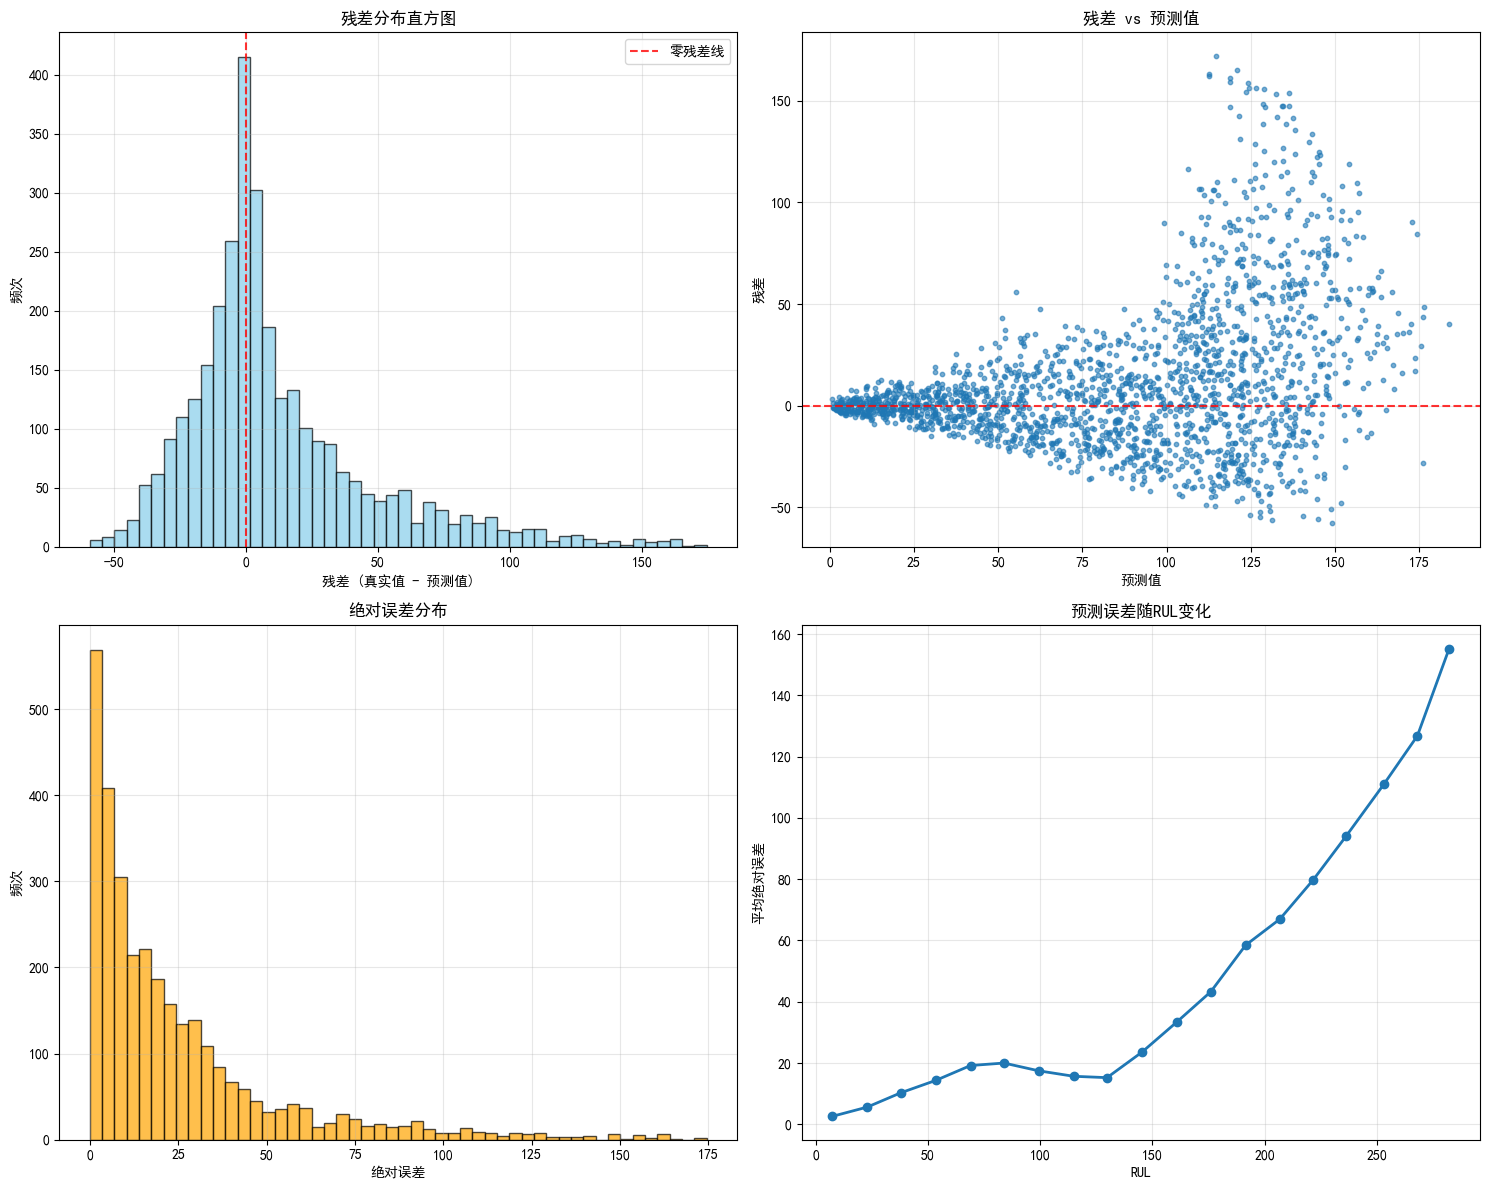


验证集统计:
残差均值: 11.971
残差标准差: 35.972
最大正残差: 174.463
最大负残差: -59.104
平均绝对误差: 24.733
误差在±5周期内: 24.2%
误差在±10周期内: 39.7%
误差在±20周期内: 59.1%

=== 测试集残差分析 ===


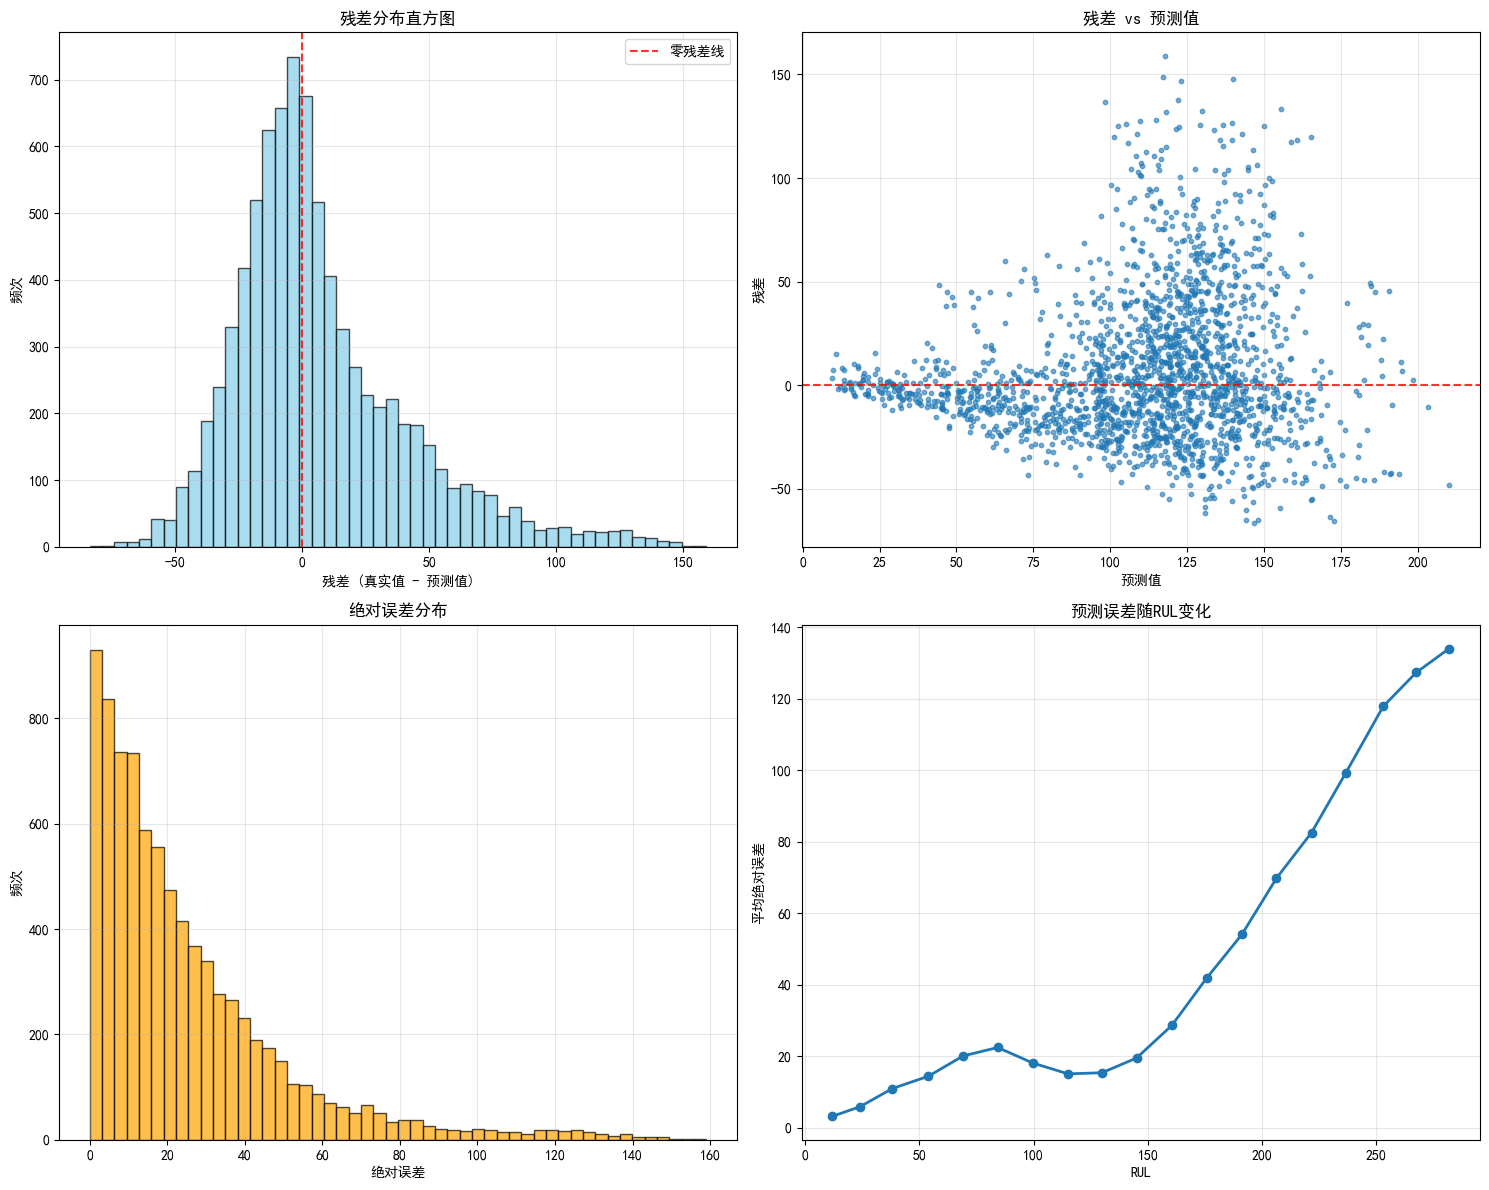


测试集统计:
残差均值: 7.052
残差标准差: 34.695
最大正残差: 159.061
最大负残差: -83.560
平均绝对误差: 25.109
误差在±5周期内: 17.4%
误差在±10周期内: 31.5%
误差在±20周期内: 54.7%


In [39]:
# 残差分析
def analyze_residuals(y_true, y_pred, title="残差分析"):
    """
    分析预测残差
    """
    residuals = y_true - y_pred
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 残差直方图
    ax1.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='零残差线')
    ax1.set_title('残差分布直方图')
    ax1.set_xlabel('残差 (真实值 - 预测值)')
    ax1.set_ylabel('频次')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 残差散点图
    sample_size = min(2000, len(y_pred))
    indices = np.random.choice(len(y_pred), sample_size, replace=False)
    ax2.scatter(y_pred[indices], residuals[indices], alpha=0.6, s=10)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax2.set_title('残差 vs 预测值')
    ax2.set_xlabel('预测值')
    ax2.set_ylabel('残差')
    ax2.grid(True, alpha=0.3)
    
    # 3. 绝对误差分布
    abs_errors = np.abs(residuals)
    ax3.hist(abs_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax3.set_title('绝对误差分布')
    ax3.set_xlabel('绝对误差')
    ax3.set_ylabel('频次')
    ax3.grid(True, alpha=0.3)
    
    # 4. 误差随RUL变化
    # 按RUL值分组计算平均误差
    rul_bins = np.linspace(0, y_true.max(), 20)
    rul_indices = np.digitize(y_true, rul_bins)
    
    bin_means = []
    bin_errors = []
    
    for i in range(1, len(rul_bins)):
        mask = (rul_indices == i)
        if np.sum(mask) > 0:
            bin_means.append(np.mean(y_true[mask]))
            bin_errors.append(np.mean(abs_errors[mask]))
    
    if bin_means:
        ax4.plot(bin_means, bin_errors, 'o-', linewidth=2, markersize=6)
        ax4.set_title('预测误差随RUL变化')
        ax4.set_xlabel('RUL')
        ax4.set_ylabel('平均绝对误差')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n{title}统计:")
    print(f"残差均值: {residuals.mean():.3f}")
    print(f"残差标准差: {residuals.std():.3f}")
    print(f"最大正残差: {residuals.max():.3f}")
    print(f"最大负残差: {residuals.min():.3f}")
    print(f"平均绝对误差: {abs_errors.mean():.3f}")
    print(f"误差在±5周期内: {np.mean(abs_errors <= 5)*100:.1f}%")
    print(f"误差在±10周期内: {np.mean(abs_errors <= 10)*100:.1f}%")
    print(f"误差在±20周期内: {np.mean(abs_errors <= 20)*100:.1f}%")

# 分析验证集残差
print("=== 验证集残差分析 ===")
analyze_residuals(y_val_split, y_val_pred, "验证集")

# 分析测试集残差
print("\n=== 测试集残差分析 ===")
analyze_residuals(y_test_windows, y_test_pred, "测试集")